# Capstone project: E-commerce Analysis and Time Series Demand Forecasting
Janet Ting, DSIF-6

Notebook 3 of 4

<a id="toc"></a>
# Table of contents
1. **[Project Setup](#setup)**
2. **[Anomalies Detection and Explanation](#clean)**
3. **[Data Visualization](#viz)**
4. **[Data Splitting](#split)**
4. **[Data Transformation](#trans)**
5. **[Stationary Tests](#tests)**
6. **[Data Modelling](#model)**
7. **[Model Evaluation](#compare)**
8. **[Forecast](#forecast)**

In this section we focus on Univariate time series forecasting methods which capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

<u> Objective </u>
* To forecast order counts for the next two months using Time-Series model, with the least forecast error in terms of root_mean_square_error (RMSE) and less than 25% for symmetric_mean_absolute_percentage_error (SMAPE). As according to [white paper](https://www.e2open.com/wp-content/uploads/2019/02/2018_Forecasting_and_Inventory_Benchmark_Study_white_paper_digital.pdf)  in 2018, the most forecastable business have an error of 29%.

<u> Experiment Setup </u>
* Enviroment: 5-fold Time-series cross validation (7-days forecast in the Test Set). Find the best combination between 4 data transformations + 4 time-series models. 

<u> Performance Metric </u>
* Metrics: Model is selected based on the least average RMSE and SMAPE.  
___
A model performance can be tested by evaluating a comparison between the actual values and the predicted values. In this project, two performance metrics, namely the root mean square error (RMSE), symmetric mean absolute percentage error (SMAPE) are used to evaluate the performance of each model. These metrics are calculated using the following equations;

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2} = \sqrt{MSE}$$

$$SMAPE = \frac{100\%}{n}\sum_{i=1}^n\frac{|y_i-\hat{y}_i|2}{|y_i|-|\hat{y}_i|}$$

When dealing with regression or forecasting problems, general metrics that we use are RMSE, MAE etc. RMSE, MAE are good if we are dealing with in small ranges and if the variation is very less. RMSE is helpful to get an idea of the magnitude of errors in terms of number of sales, but relative ones like SMAPE might be more interpretable.

In general use cases, we see data with lot of variation and when we look at RMSE metric, the values may not seem sensible. In such cases, we can go with MAPE or sMAPE. In these two metrics, we are looking at how much forecast is deviating from actual in percentages. One of the drawbacks of using MAPE is that the values will be asymmetric, meaning, it is biased towards large values.

When doing demand forecasting of any low quantity items or LTV predictions in range of 5–10 or any sparse predictions, because the value will be very low and error will be very high even if we are off by absolute difference of low value. To avoid such problems, SMAPE is a better metric.

While this addresses one kind of asymmetric nature, but it creates another asymmetric value because of denominator while we overpredict and underpredict. If we underpredict, the sMAPE will be higher compared to overprediction, because the difference raised with Predicted in both the cases.

Goal: Get $RMSE$ as close to 0 as possible and $SMAPE$ to be 0% ideally. Higher score indicates a higher error rate. E-commerce standard of SMAPE is 10-25%.

|        Metric        |    Pros   | Cons |  
|:-------------------:|:--------------:|:-------:|
|         RMSE         |  - Represents (approximately) average distance from the predicted value (similar to standard deviation).  |    - Can be heavily affected by outliers. _(mostly from outlier data in y_true)_   |
|         RMSE         | - In the original units of $Y$. _(sqrt(MSE), scales down the amplification that happens from all the residual squaring in MSE)_ |    - Scale dependent on of $Y$. |
|         RMSE         | -  |    - Only a _little_ interpretable.   |
|         SMAPE         | - Expressed as a percentage. |    - Value can be high if underpredict.   |
|         SMAPE         | - Fixes the shortcoming of the original MAPE  |    -  |
|         SMAPE         | - It has both the lower (0%) and the upper (200%) bounds. |    -    |
___

<u> Baseline </u>: The original time-series dataset for each model without data tranformation. 

<u> Experiments Components </u>:
* [4 Data transformations](#trans):
  * Original time-series dataset
  * Time-series Deseasonalized with STL Decomposition
  * Time-series Transformed with Box-cox Tranformation 
  * Time-series with Seasonal Differencing 
* 4 Time-series models:
  * [Time-series regression](#res_reg)
  * [Holt-winter's exponential smoothing](#res_es)
  * [Auto ARIMA](#res_arima)
  * [Long-short term memory/ LSTM](#res_lstm)
* Grid-search hyperparameters space:
  * Holt-winter's exponential smoothing
    * Smoothing Level, $\alpha$: 0, 1, 2, ..., 7, 8, 9
    * Smoothing Trend, $\beta$: 0, 1, 2, ..., 7, 8, 9
    * Smoothing Seasonal, $\gamma$: 0, 1, 2, ..., 7, 8, 9
  * LSTM
    * Adam learning rate: 0.001, 0.01, 0.1, 1, 10


<a id="setup"></a>
# [&#8629;](#toc) Project Setup

In [1]:
# Install Packages
# !pip install calmap
# !pip install pmdarima

In [2]:
# Import Libraries
import datetime
import os
import random
import re
from itertools import cycle, product

import calmap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from IPython.display import display
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from pmdarima.arima import ARIMA as pmdARIMA
from pmdarima.arima import ADFTest, KPSSTest, auto_arima
from pmdarima.utils import diff_inv
from pmdarima.metrics import smape
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from tensorflow.keras.optimizers import Adam

In [3]:
import pickle

In [4]:
# Deep Learning Setup
MAX_EPOCHS = 25
N_FEATURES = 7
SEED = 1234

<a id="clean"></a>
# [&#8629;](#toc) Anomalies Detection and Explanation

In [5]:
# Read Data
orders = pd.read_csv('../datasets/orders_items_prod_re.csv')
orders.head()

Unnamed: 0                          order_id  \
0           0  e481f51cbdc54678b7cc49136f2d6af7   
1           1  53cdb2fc8bc7dce0b6741e2150273451   
2           2  47770eb9100c2d0c44946d9cf07ec65d   
3           3  949d5b44dbf5de918fe9c16f97b45f8a   
4           4  ad21c59c0840e6cb83a9ceb5573f8159   

                        customer_id order_status order_purchase_timestamp  \
0  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37   
2  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49   
3  f88197465ea7920adcdbec7375364d82    delivered      2017-11-18 19:28:06   
4  8ab97904e6daea8866dbdbc4fb7aad2c    delivered      2018-02-13 21:18:39   

     order_approved_at order_delivered_carrier_date  \
0  2017-10-02 11:07:15          2017-10-04 19:55:00   
1  2018-07-26 03:24:27          2018-07-26 14:31:00   
2  2018-08-08 08:55:23          2018-08-08 13:50:00   
3  2017-11-18 19:45:59          2017-11-22 13:39:59   
4  2018-02-13 22:20:29          2018-02-14 19:46:34   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13           2017-10-18 00:00:00   
1           2018-08-07 15:27:45           2018-08-13 00:00:00   
2           2018-08-17 18:06:29           2018-09-04 00:00:00   
3           2017-12-02 00:28:42           2017-12-15 00:00:00   
4           2018-02-16 18:17:02           2018-02-26 00:00:00   

                 customer_unique_id  ...  \
0  7c396fd4830fd04220f754e42b4e5bff  ...   
1  af07308b275d755c9edb36a90c618231  ...   
2  3a653a41f6f9fc3d2a113cf8398680e8  ...   
3  7c142cf63193a1473d2e66489a9ae977  ...   
4  72632f0f9dd73dfee390c9b22eb56dd6  ...   

                              review_comment_message review_creation_date  \
0  Não testei o produto ainda, mas ele veio corre...  2017-10-11 00:00:00   
1                               Muito bom o produto.  2018-08-08 00:00:00   
2                                                NaN  2018-08-18 00:00:00   
3  O produto foi exatamente o que eu esperava e e...  2017-12-03 00:00:00   
4                                                NaN  2018-02-17 00:00:00   

  review_answer_timestamp  delivery_time estimated_delivery_time  \
0     2017-10-12 03:43:48       8.429144               15.536632   
1     2018-08-08 18:37:50      12.502292               17.858021   
2     2018-08-22 19:07:58       9.382708               26.628206   
3     2017-12-05 19:21:58      13.196331               26.176400   
4     2018-02-18 13:02:51       2.830938               12.069109   

  delivery_time_delta order_approved_date  isholiday_order_purchased  \
0            7.107488          2017-10-02                        0.0   
1            5.355729          2018-07-26                        0.0   
2           17.245498          2018-08-08                        0.0   
3           12.980069          2017-11-18                        0.0   
4            9.238171          2018-02-13                        1.0   

   isholiday_order_approved  product_m3  
0                         0    0.001976  
1                         0    0.004693  
2                         0    0.009576  
3                         0    0.006000  
4                         0    0.011475  

[5 rows x 61 columns]

The count of the unique rows of `order_purchase_timestamp` is taken as count of the unique `order_item_id` - sales quantity, our target variable. This is the case when each purchase timestamp contains unique `order_id`. 

In [6]:
full_history = pd.to_datetime(orders['order_purchase_timestamp']).dt.date
start = full_history.min()
end = full_history.max()
idx = pd.date_range(start, end, normalize=True)
full_history = (
    full_history
    .value_counts(sort=False)
    .sort_index()
    .reindex(idx, fill_value=0)
)

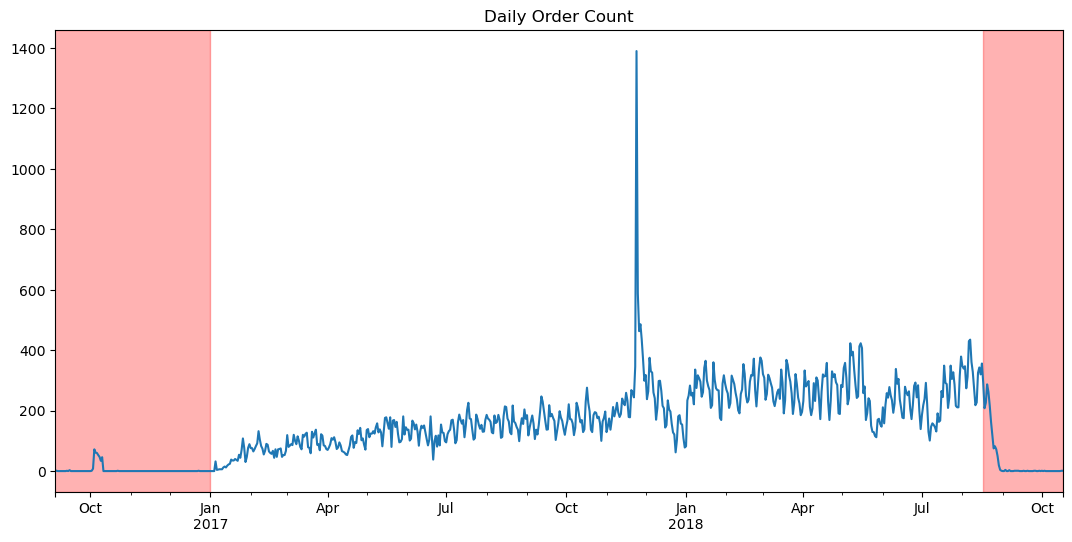

In [7]:
fig, ax = plt.subplots(figsize=(13, 6))
full_history.plot(ax=ax)
ax.axvspan(datetime.date(2016, 9, 1), datetime.date(2017, 1, 1), color='red', alpha=0.3)
ax.axvspan(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17), color='red', alpha=0.3)
ax.set_title('Daily Order Count')
plt.show()

We have full history of 2 years datas between September 2016 and October 2018.

3 Anomalies Found:
* 1 Point Anomaly 
  * 24th November 2017 (Black Friday Sales)
* 2 Collective Anomalies
  * 1st September 2016 - 31st December 2016 ([November: Rolled out new version](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/discussion/69728))
  * 17th August 2017 - 17th October 2017
  
Action:
* No clues on the second collective anomaly (Aug 17 - Oct 17), we suspect it is a data collection issue, hence we would like to predict on this interval.
* Removing two collective anomalies, because these data aren't helping to make forecast
* Retaining Point Anomaly because it is a natural anomaly which is expected to be happened when on sales.

In [8]:
# Remove outliers
history = full_history[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_period = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))

<a id="viz"></a>
# [&#8629;](#toc) Data Visualization

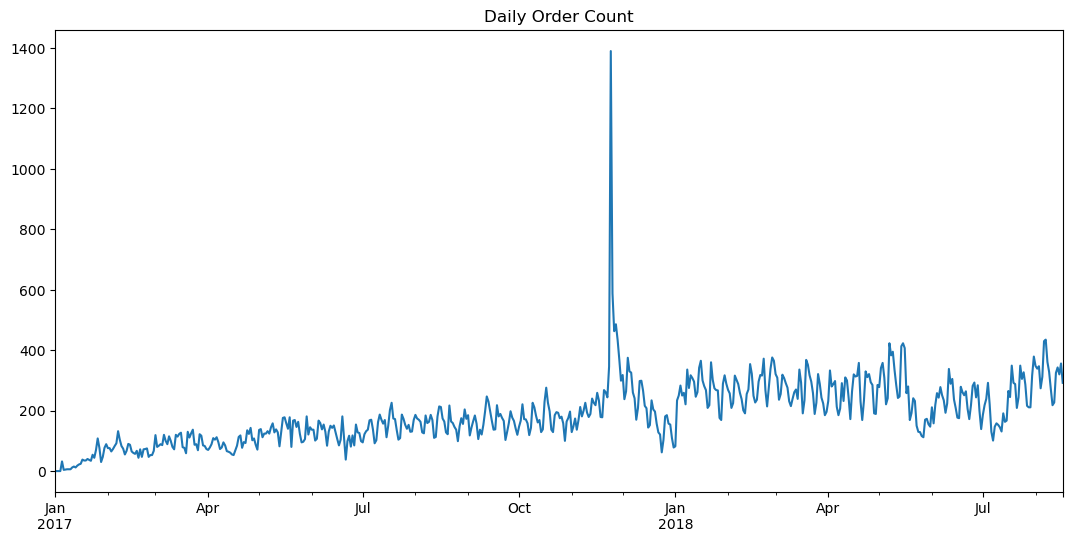

In [9]:
fig, ax = plt.subplots(figsize=(13, 6))
history.plot(ax=ax)
ax.set_title('Daily Order Count')
plt.show()

Plot timeseries as calendar heatmap

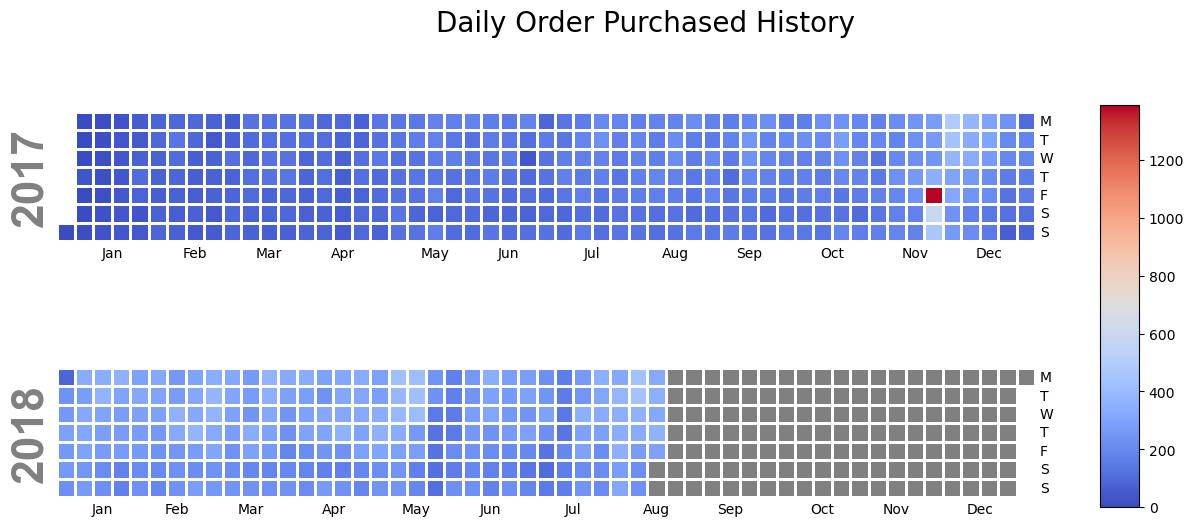

In [10]:
fig, caxs = calmap.calendarplot(history, daylabels='MTWTFSS', fillcolor='grey', cmap='coolwarm', fig_kws=dict(figsize=(13, 6)))
fig.suptitle('Daily Order Purchased History', fontsize=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.67])
fig.colorbar(caxs[0].get_children()[1], cax=cbar_ax)

plt.show()

Seasonal-Trend decomposition using LOESS [(STL)](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)

STL is used to decompose a time series into three components: trend, season(al) and residual. STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components. The key inputs into STL are:
1. trend - The length of the trend smoother, usually around 150% of season. Must be odd and larger than season.It refers to the general direction in which the time series is moving. Time series can have a positive or a negative trend, but can also have no trend.
2. season - The length of the seasonal smoother. Must be odd. It refers the repeating short-term cycle in the series
3. residual - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data. This is what’s left of the time series data after removing its trend and seasonal components.

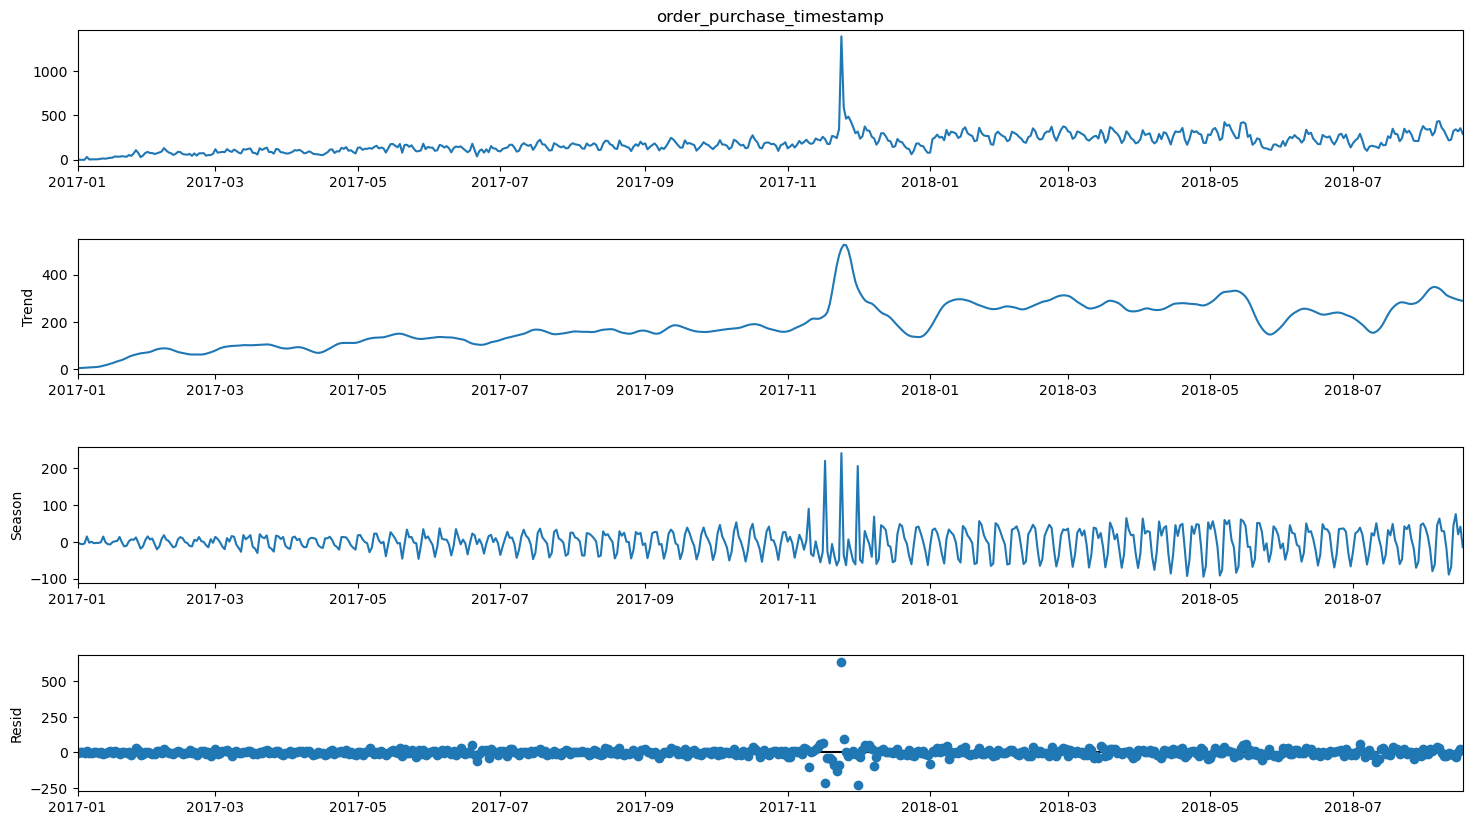

In [11]:
stl = STL(history)
stl_res = stl.fit()
fig = stl_res.plot()
fig.set_size_inches((16, 9))
plt.show()

Filter to look into time frame January 2018 to April 2018.

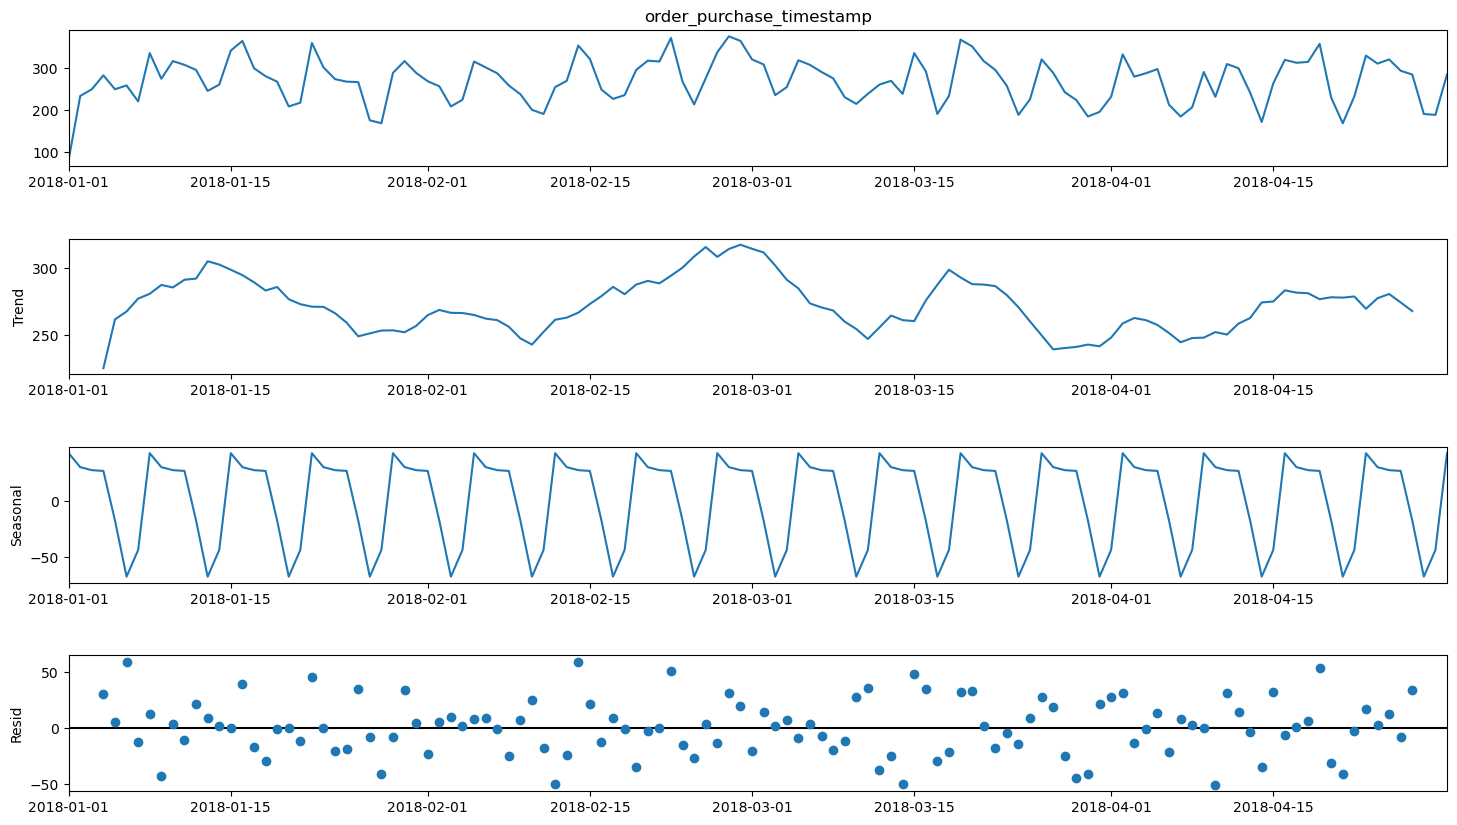

In [12]:
# time series decomposition into components
res = seasonal_decompose(history.loc['2018-01':'2018-04'], model='additive', period=7)

fig = res.plot()
fig.set_size_inches((16, 9))
plt.show()

<a id="split"></a>
# [&#8629;](#toc) Data Splitting

In [13]:
tscv = TimeSeriesSplit(max_train_size=pred_period.shape[0])

<a id="trans"></a>
# [&#8629;](#toc)  Data Transformation

Compare Original data as to Deseasonal, Boxcox, or Stationary Differencing

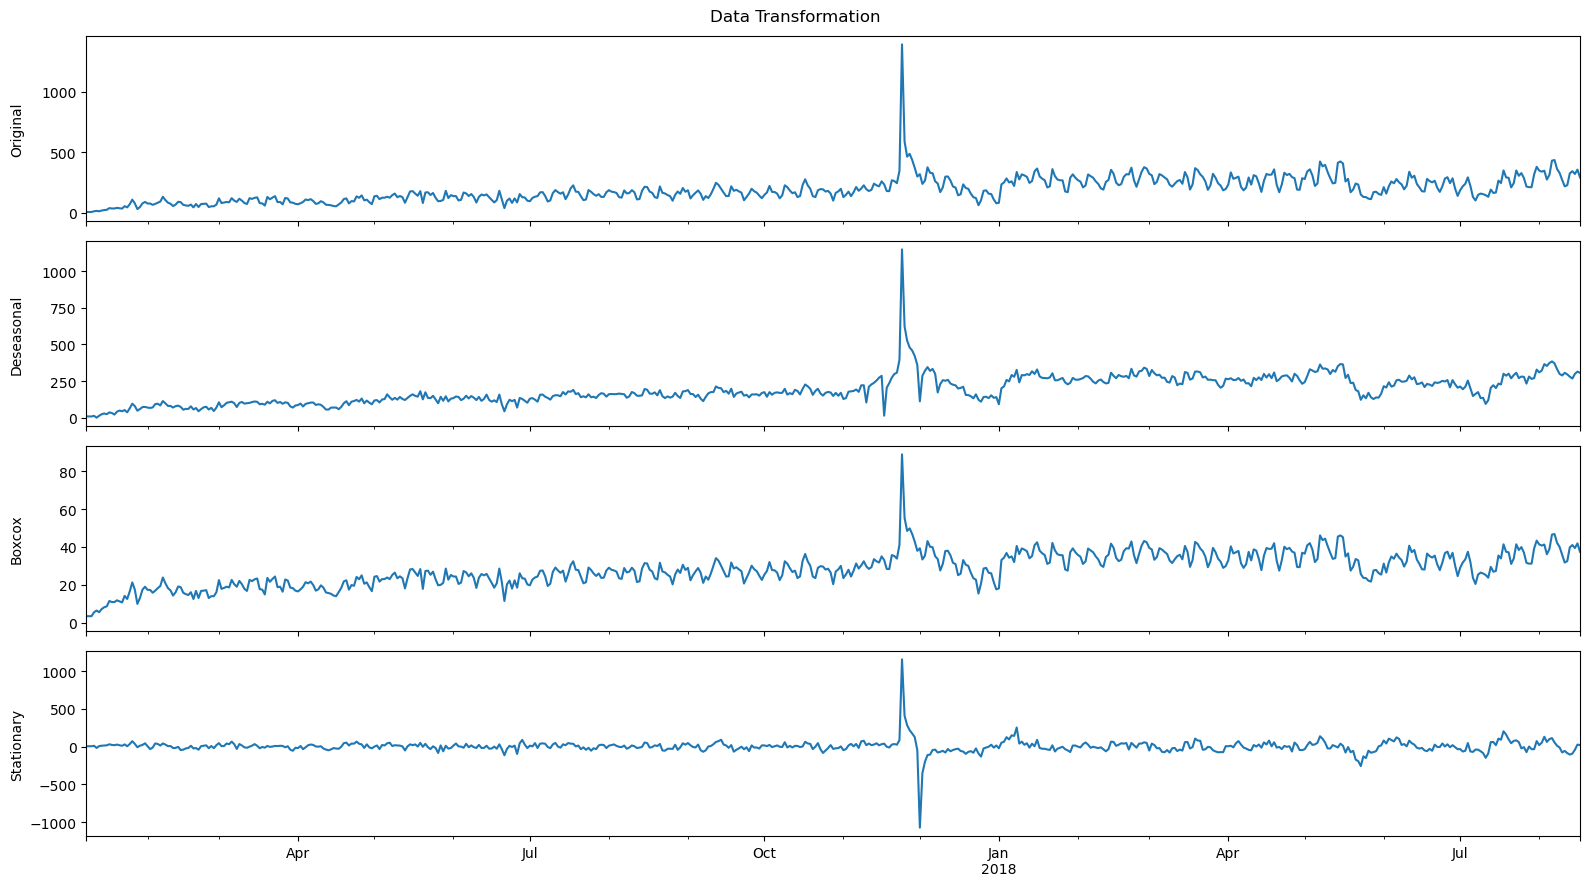

In [14]:
stl = STL(history)
res = stl.fit()
deseasonal = res.observed - res.seasonal

bc_history, lmbda = boxcox(history+1)
bc_history = pd.Series(bc_history, index=history.index)

diff_history = history.diff(7).dropna()
xi = history.iloc[:7]

fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(16,9))
history.plot(ax=axs[0])
axs[0].set_ylabel('Original')
deseasonal.plot(ax=axs[1])
axs[1].set_ylabel('Deseasonal')
bc_history.plot(ax=axs[2])
axs[2].set_ylabel('Boxcox')
diff_history.plot(ax=axs[3])
axs[3].set_ylabel('Stationary')
fig.align_ylabels()
fig.suptitle('Data Transformation')
plt.tight_layout()
plt.show()

In [15]:
def diff_inv_fix(x_diff, xi, lags=7):
    '''
    Quick fix for diff_inv
    pls refer: https://github.com/alkaline-ml/pmdarima/issues/410
    '''
    total_len = len(x_diff)+len(xi)
    ix = pd.date_range(xi.index[0], periods=total_len)
    inv = diff_inv(x_diff,lags, xi=xi) + np.fromiter(cycle(xi), count=total_len, dtype=float)
    inv = pd.Series(inv, index=ix, name='order_purchase_timestamp')
    return inv

# Checking Inverse Differencing is equivalent to original history data
(diff_inv_fix(diff_history, xi, 7) == history).all()

True

<a id="tests"></a>
# [&#8629;](#toc) Stationary Tests

The Kwiatkowski–Phillips–Schmidt–Shin [(KPSS)](https://www.statisticshowto.com/kpss-test/#:~:text=Interpreting%20the%20Results,the%20series%20is%20non%2Dstationary) test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root. A stationary time series is one where statistical properties — like the mean and variance — are constant over time. 

Result shows a first-order seasonal differencing is [sufficient](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=ADF%20concludes%20stationary%20and%20KPSS%20concludes%20non%2Dstationary) for the data to become stationary:

In [16]:
adf = ADFTest()
adf.should_diff(history)

(0.01, False)

In [17]:
adf.should_diff(diff_history)

(0.01, False)

In [18]:
kpss = KPSSTest()
kpss.should_diff(history)

(0.01, True)

In [19]:
kpss.should_diff(diff_history)

(0.1, False)

| Stationary Test| Original Data | First-Order Seasonal Differenced Data |
|----------------|:-------------:|:-------------------------------------:|
|ADF Test        |Stationary     |Stationary                             |
|KPSS Test       |Not Stationary |Stationary                             |

* For KPSS test, the null hypothesis is that the data are stationary. If we want to reject the null hypothesis. the p-value needs to be greater than 0.05 not less than 0.05.

Conclusion: The time-series achieved stationary state after first-order seasonal differencing. No further differencing needed.

From the result of both tests, it suggests that the original data is differencing stationary, therefore a differencing is to be applied and conduct the test again for further clarification. However, the time-series is becoming stationary after the data transformed with the first-order seasonal differencing, which we subtract the past-7th lag from the current timesteps. 

<a id="model"></a>
# [&#8629;](#toc) Data Modelling

Define functions to record the results and to plot the graph

In [20]:
result = pd.DataFrame(columns=['algo', 'rmse', 'smape_pct'])
def record(algo, rmse, smape_pct):
    global result
    new = pd.DataFrame(dict(algo=algo, rmse=rmse, smape_pct=smape_pct), index=[0])
    result = pd.concat([result, new], ignore_index=True)
    display(result)

In [21]:
def plot(index, pred, rmse, smape_pct, title, fig=None, ax=None):
    global history
    empty_fig = fig is None
    if empty_fig:
        fig, ax = plt.subplots(figsize=(16, 9))
        ax.set_title(title + ': Last Fold CV In-Sample Forecasting')
    else:
        ax.set_title(title)
        models = ['', 'STL', 'Boxcox', 'Seasonal Diff']
        ylabels = ['Original', 'Deseasonal', 'Boxcox', 'Stationary']
        for model, ylabel in zip(models, ylabels):
            if re.sub(r'[^\+]+(\s\+\s)?([^\+]+)?$', r'\g<2>', title) == model:
                ax.set_ylabel(ylabel)
                
    patch_ = mpatches.Patch(color='white', label=f"RMSE: {np.mean(rmse):.1f} ")  #,SMAPE {np.mean(smape):.2f}
    L1 = ax.legend(handles=[patch_], loc='upper left', fancybox=True, framealpha=0.7,  handlelength=0)
    ax.add_artist(L1)
    sns.lineplot(x=history.index, y=history, label='true', ax=ax)
    sns.lineplot(x=index, y=pred, label='pred', ax=ax)
    ax.axvline(x=index[0], color='red')
    ax.legend(loc='upper right')
    if empty_fig:
        plt.show()
    else:
        return fig

## 1A. Time Series Regression
Linear Regression with 7 Lags as input

In [22]:
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(16, 9))
figs.suptitle('Last Fold CV In-Sample Forecasting')
figs.tight_layout()
plt.close()

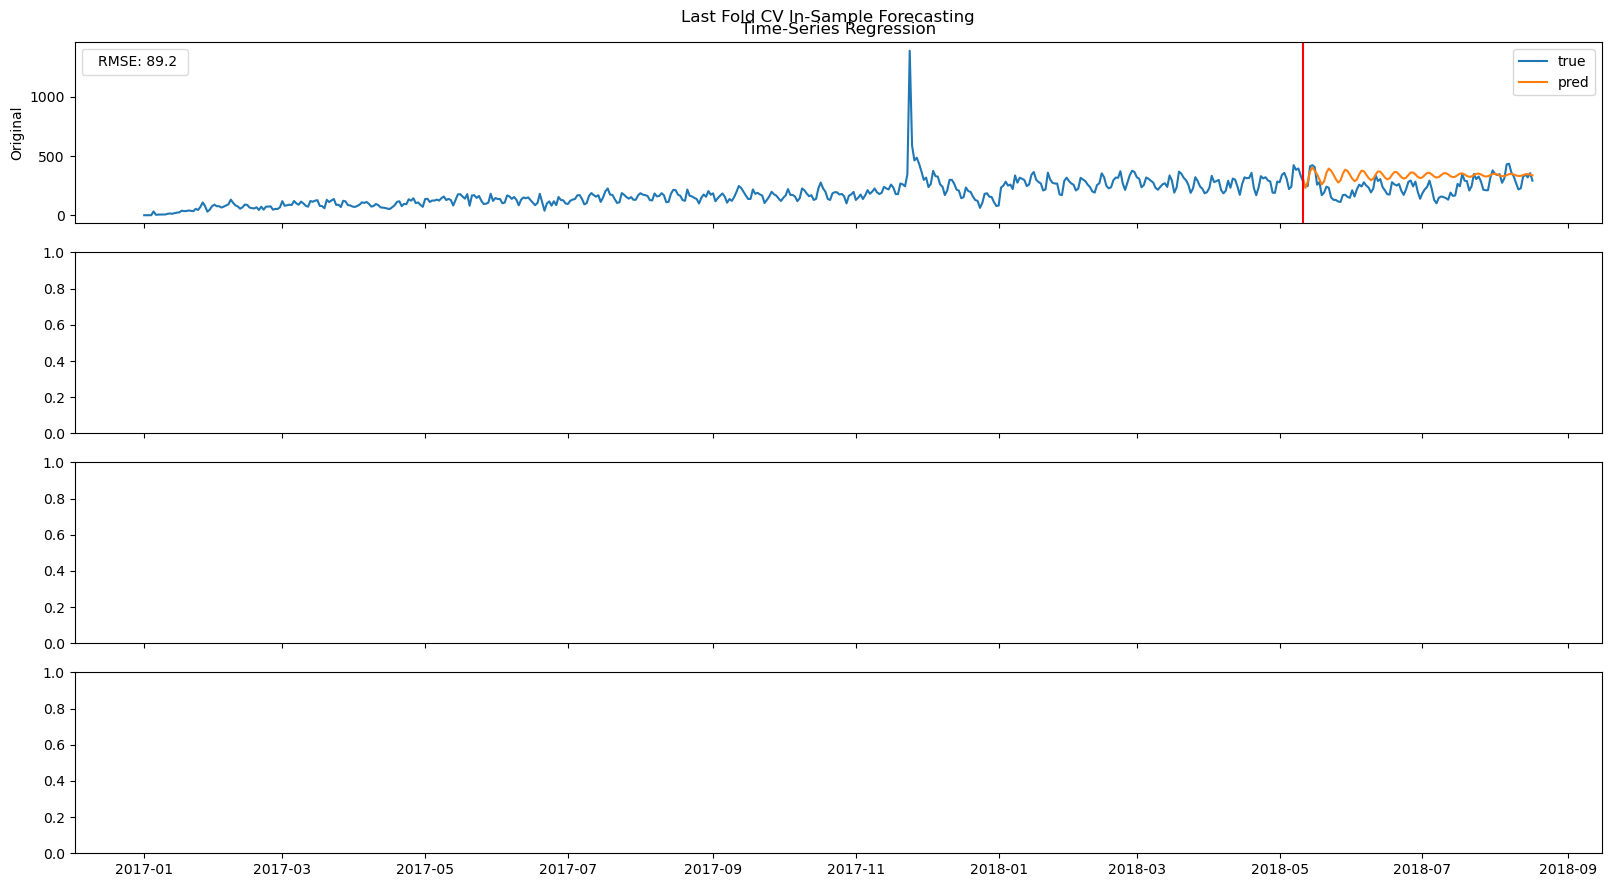

In [23]:
title = 'Time-Series Regression'
data = history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    gen = TimeseriesGenerator(train, train, length=N_FEATURES, batch_size=1000)
    X_train = gen[0][0]
    y_train = gen[0][1]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-N_FEATURES:].reshape(1,-1)
    y_pred = np.empty(y_test.shape[0])
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1,1)), 1)    
        y_pred[i] = forecast
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    # print('Test SMAPE: %.3f' % smape(y_test, y_pred))
    smape_pct.append(smape(y_test, y_pred))
plot(y_test.index, y_pred, rmse, smape_pct, title, figs, axs[0])

In [24]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo       rmse  smape_pct
0  Time-Series Regression  89.229542    30.7491

## 1B. Time Series Regression + STL Decomposition

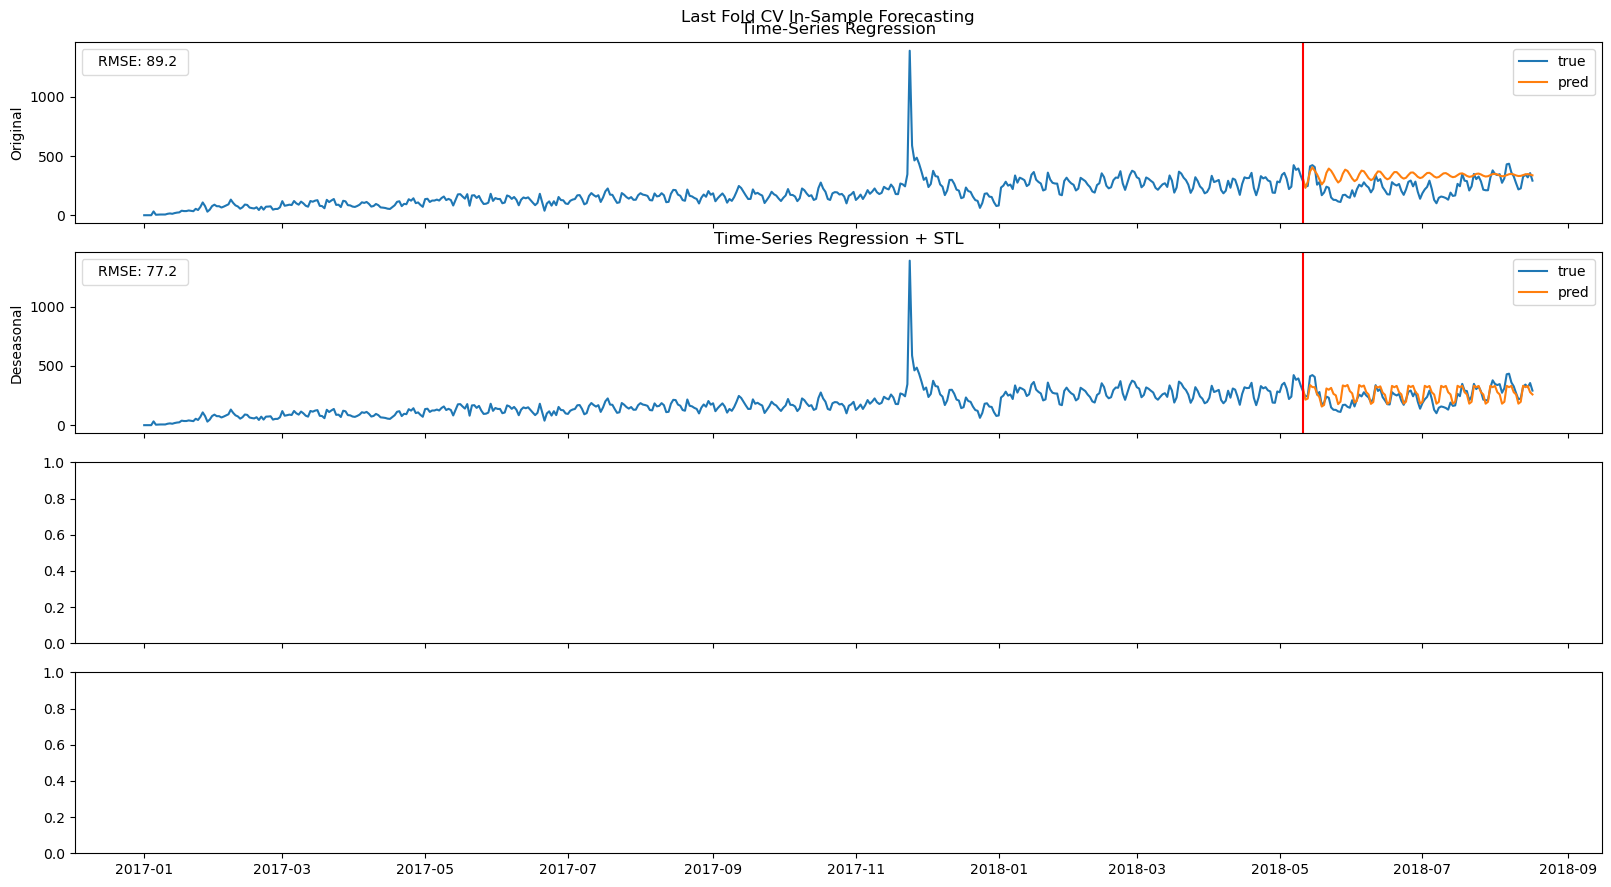

In [25]:
title = 'Time-Series Regression + STL'
data = deseasonal.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    gen = TimeseriesGenerator(train, train, length=N_FEATURES, batch_size=1000)
    X_train = gen[0][0]
    y_train = gen[0][1]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-N_FEATURES:].reshape(1,-1)
    y_pred = np.empty(y_test.shape[0])
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1,1)), 1)    
        y_pred[i] = forecast
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    y_pred = y_pred + np.fromiter(cycle(last_seasonal), count=y_pred.shape[0], dtype=float)
    y_test = y_test + res.seasonal.reindex_like(y_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    smape_pct.append(smape(y_test, y_pred))
plot(y_test.index, y_pred, rmse, smape_pct, title, figs, axs[1])

In [26]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo       rmse  smape_pct
0        Time-Series Regression  89.229542  30.749100
1  Time-Series Regression + STL  77.199685  27.672147

## 1C. Time-Series + Box-Cox

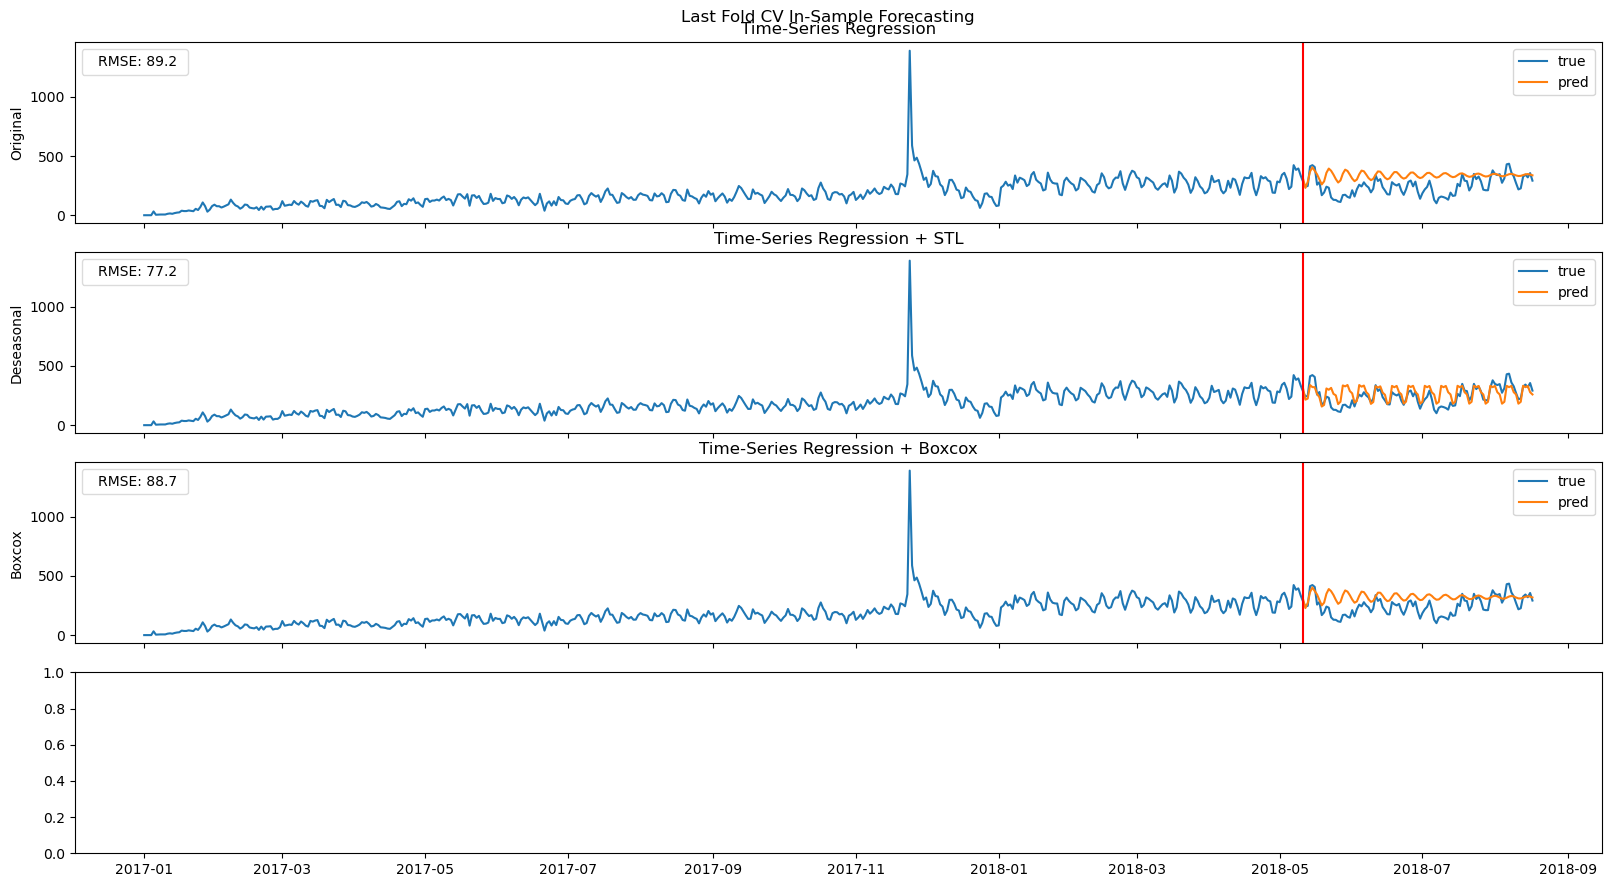

In [27]:
title = 'Time-Series Regression + Boxcox'
data = bc_history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    gen = TimeseriesGenerator(train, train, length=N_FEATURES, batch_size=1000)
    X_train = gen[0][0]
    y_train = gen[0][1]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-N_FEATURES:].reshape(1,-1)
    y_pred = np.empty(y_test.shape[0])
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1,1)), 1)    
        y_pred[i] = forecast
    y_pred = inv_boxcox1p(y_pred, lmbda)
    y_test = inv_boxcox1p(y_test, lmbda)
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    smape_pct.append(smape(y_test, y_pred))
plot(y_test.index, y_pred, rmse, smape_pct, title, figs, axs[2])

In [28]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo       rmse  smape_pct
0           Time-Series Regression  89.229542  30.749100
1     Time-Series Regression + STL  77.199685  27.672147
2  Time-Series Regression + Boxcox  88.674419  31.035474

## 1D. Time-Series + Seasonal Differencing

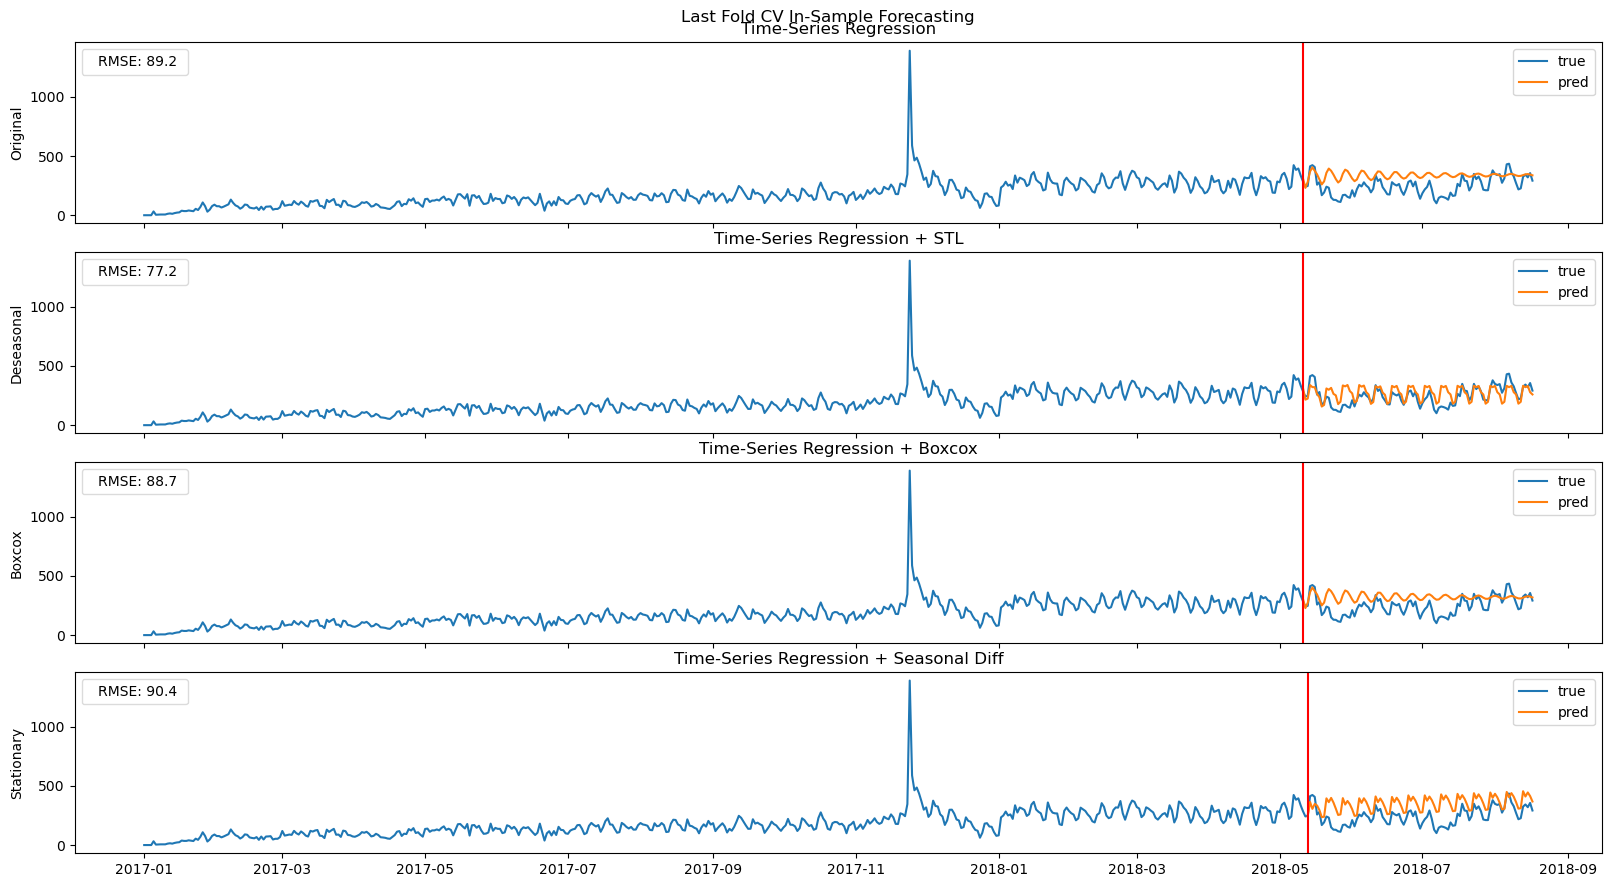

In [29]:
title = 'Time-Series Regression + Seasonal Diff'
data = diff_history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    gen = TimeseriesGenerator(train, train, length=N_FEATURES, batch_size=1000)
    X_train = gen[0][0]
    y_train = gen[0][1]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-N_FEATURES:].reshape(1,-1)
    y_pred = np.empty(y_test.shape[0])
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1,1)), 1)    
        y_pred[i] = forecast
    xi = history.reindex_like(train).tail(N_FEATURES)
    y_pred = diff_inv_fix(y_pred, xi).iloc[N_FEATURES:]
    y_test = diff_inv_fix(y_test, xi).iloc[N_FEATURES:]
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    smape_pct.append(smape(y_test, y_pred))
plot(y_test.index, y_pred, rmse, smape_pct, title, figs, axs[3])

In [30]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo       rmse  smape_pct
0                  Time-Series Regression  89.229542  30.749100
1            Time-Series Regression + STL  77.199685  27.672147
2         Time-Series Regression + Boxcox  88.674419  31.035474
3  Time-Series Regression + Seasonal Diff  90.438505  28.289077

## 2A. Exponential Smoothing

<u>`Exponential Smoothing`</u> models generate forecasts by using weighted averages of past observations to predict new values. The weights decaying exponentially as the observations get older. 

The essence of these models (such as Holt-Winters seasonal method) is in combining Error, Trend, and Seasonal components into a smooth calculation together with the forecast equation, as cited from [Forecasting: Principles and Practice](https://otexts.com/fpp2/expsmooth.html)

Performed grid search over the parameters - alpha, beta and gamma with criteria of minimum RMSE to improve this model.

In [31]:
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(16,9))
figs.suptitle('Last Fold CV In-Sample Forecasting')
figs.align_ylabels()
figs.tight_layout()
plt.close()

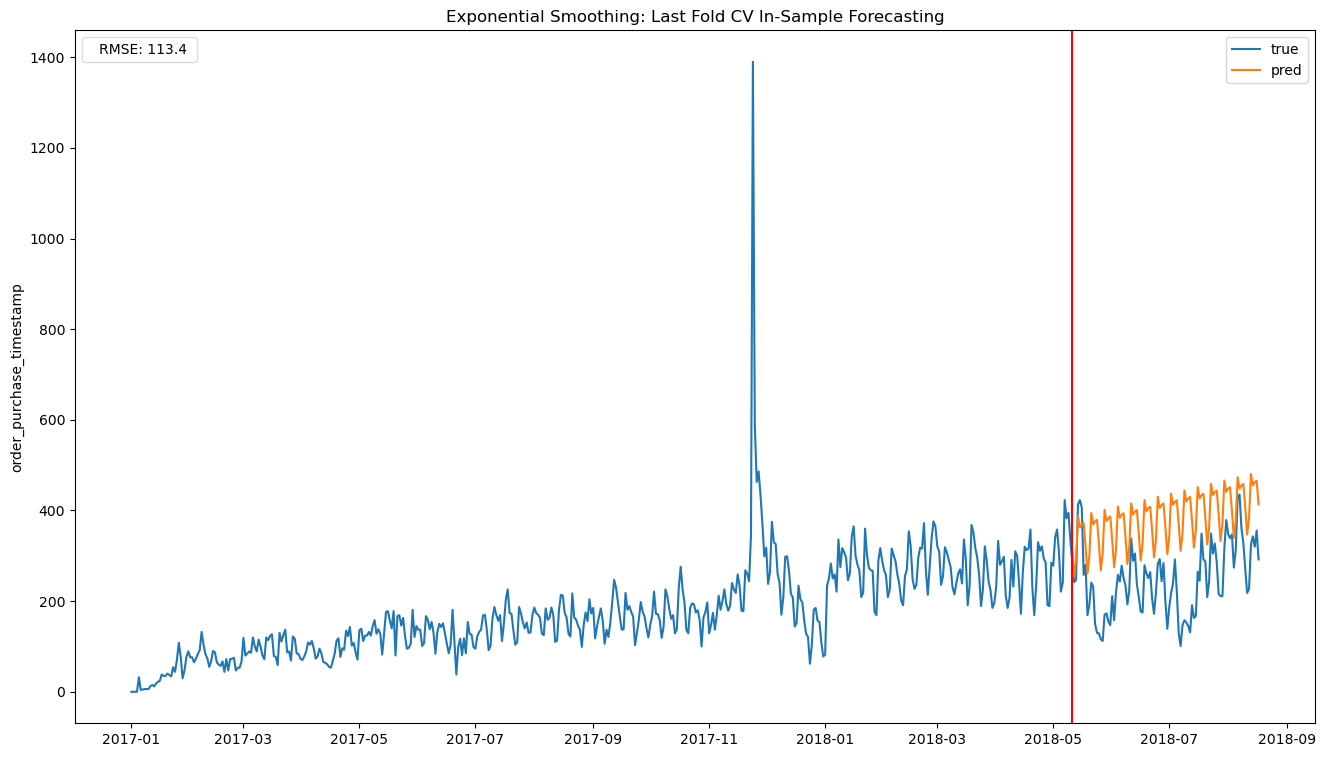

In [32]:
title = 'Exponential Smoothing'
data = history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7).fit(method='ls')
    pred = ES.forecast(test.shape[0])
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Searching on the best Parameters

In [33]:
def gscv(alpha, beta, gamma):
    global history
    data = history.copy()
    rmse = []
    smape_pct = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        ES = (
            ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
            .fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls')
        )
        pred = ES.forecast(test.shape[0])
        rmse.append(np.sqrt(mean_squared_error(test, pred)))
        smape_pct.append(smape(test, pred)) 
    return np.mean(rmse)

alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning

alpha  beta  gamma
0      0.0   0.0    0.0
1      0.0   0.0    0.1
2      0.0   0.0    0.2
3      0.0   0.0    0.3
4      0.0   0.0    0.4
..     ...   ...    ...
995    0.9   0.9    0.5
996    0.9   0.9    0.6
997    0.9   0.9    0.7
998    0.9   0.9    0.8
999    0.9   0.9    0.9

[1000 rows x 3 columns]

In [34]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.alpha, x.beta, x.gamma), axis=1)

Wall time: 31 s


In [35]:
tuning.query('rmse == rmse.min()')

alpha  beta  gamma       rmse
33    0.0   0.3    0.3  73.152984

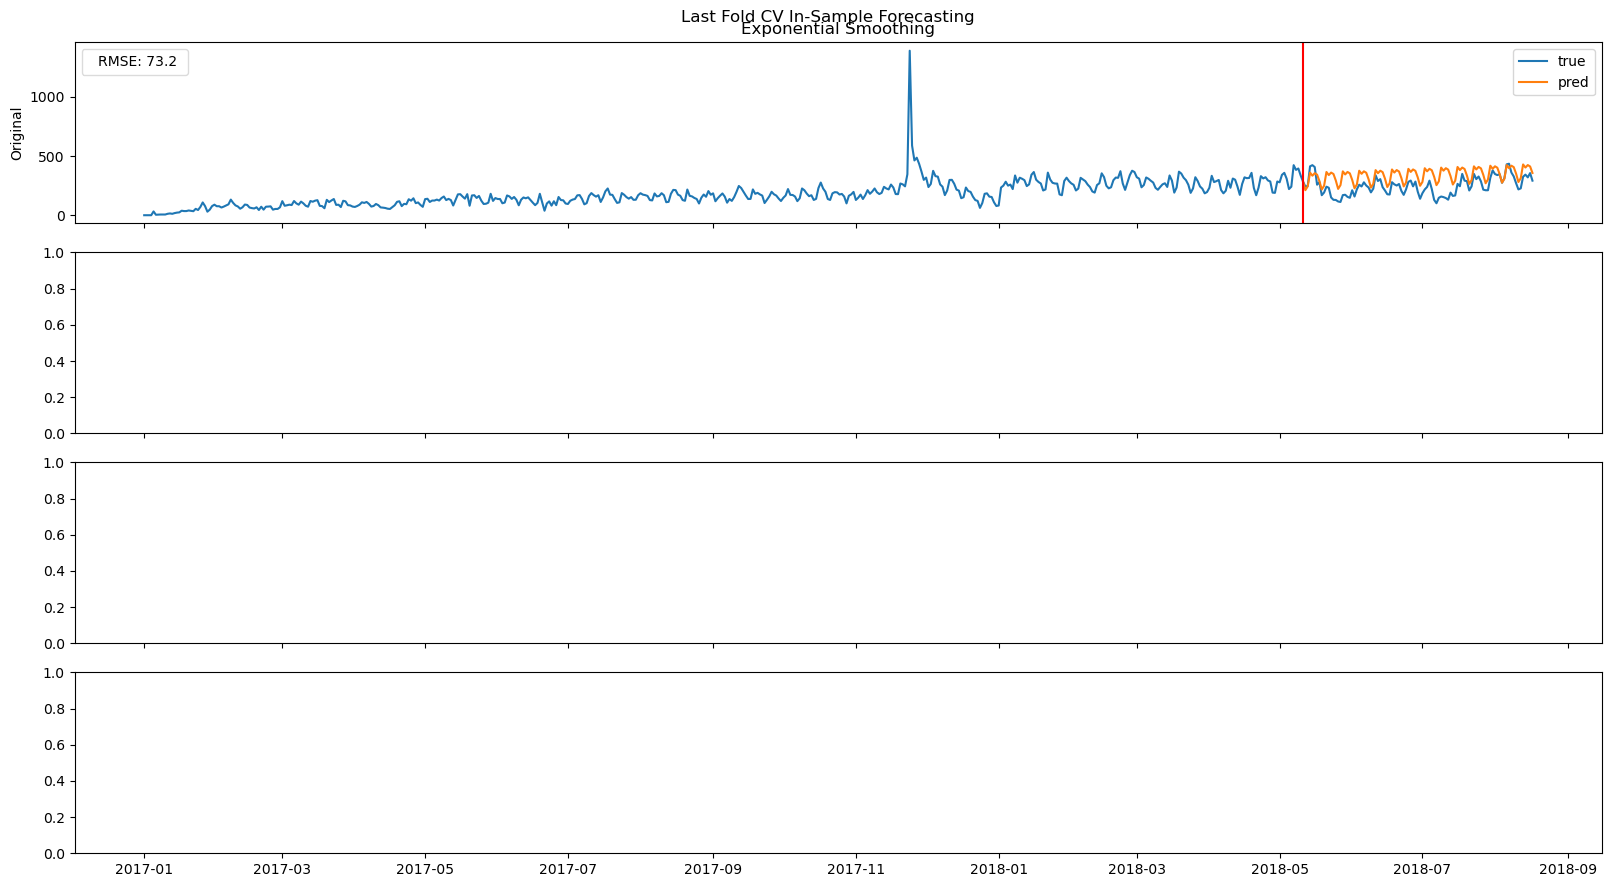

In [36]:
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = (
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
        .fit(smoothing_level=0, smoothing_trend=0.3, smoothing_seasonal=0.3, method='ls')
    )
    pred = ES.forecast(test.shape[0])
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[0])

In [37]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo       rmse  smape_pct
0                  Time-Series Regression  89.229542  30.749100
1            Time-Series Regression + STL  77.199685  27.672147
2         Time-Series Regression + Boxcox  88.674419  31.035474
3  Time-Series Regression + Seasonal Diff  90.438505  28.289077
4                   Exponential Smoothing  73.152984  21.895807

## 2B. Exponential Smoothing with STL Decomposition (Seasonal-Trend and Residual)
Deseasonal data is used to fit exponential smooothing model. STLForecast simplifies the process of using STL to remove seasonalities and then using a standard time-series model to forecast the trend and cyclical components.

Performed grid search over the parameters - alpha, beta and gamma with criteria of minimum RMSE to improve this model.

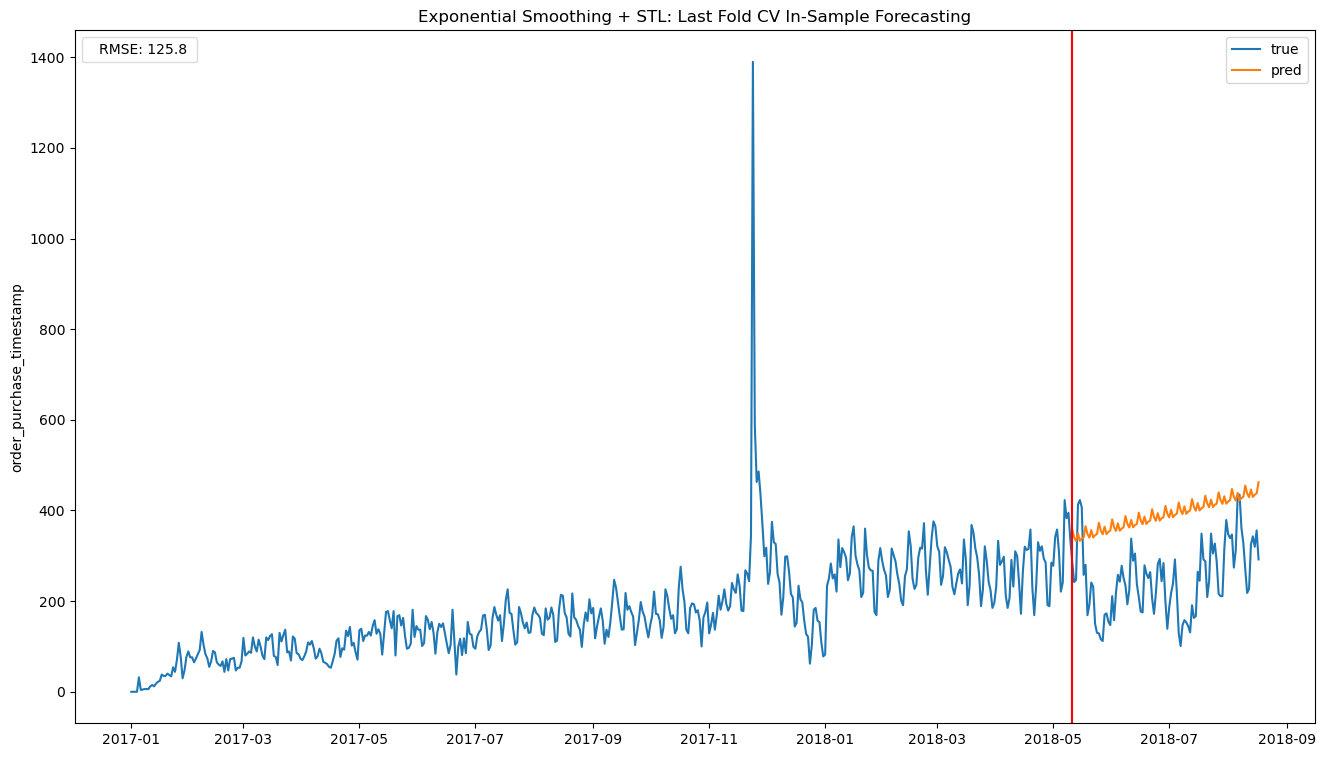

In [38]:
title = 'Exponential Smoothing + STL'
data = deseasonal.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = ExponentialSmoothing
    model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=7)
    fit_kwargs = dict(method='ls')
    stlf = STLForecast(train, ES, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
    pred = stlf.forecast(test.shape[0])
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Searching on the best Parameters

In [39]:
def gscv(alpha, beta, gamma):
    global history
    data = deseasonal.copy()
    rmse = []
    smape_pct = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        ES = ExponentialSmoothing
        model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=7)
        fit_kwargs = dict(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls')
        stlf = STLForecast(train, ES, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
        pred = stlf.forecast(test.shape[0])
        rmse.append(np.sqrt(mean_squared_error(test, pred)))
        smape_pct.append(smape(test,pred))
    return np.mean(rmse)

alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning

alpha  beta  gamma
0      0.0   0.0    0.0
1      0.0   0.0    0.1
2      0.0   0.0    0.2
3      0.0   0.0    0.3
4      0.0   0.0    0.4
..     ...   ...    ...
995    0.9   0.9    0.5
996    0.9   0.9    0.6
997    0.9   0.9    0.7
998    0.9   0.9    0.8
999    0.9   0.9    0.9

[1000 rows x 3 columns]

In [40]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.alpha, x.beta, x.gamma), axis=1)

Wall time: 38 s


In [41]:
tuning.query('rmse == rmse.min()')

alpha  beta  gamma       rmse
34    0.0   0.3    0.4  67.175504

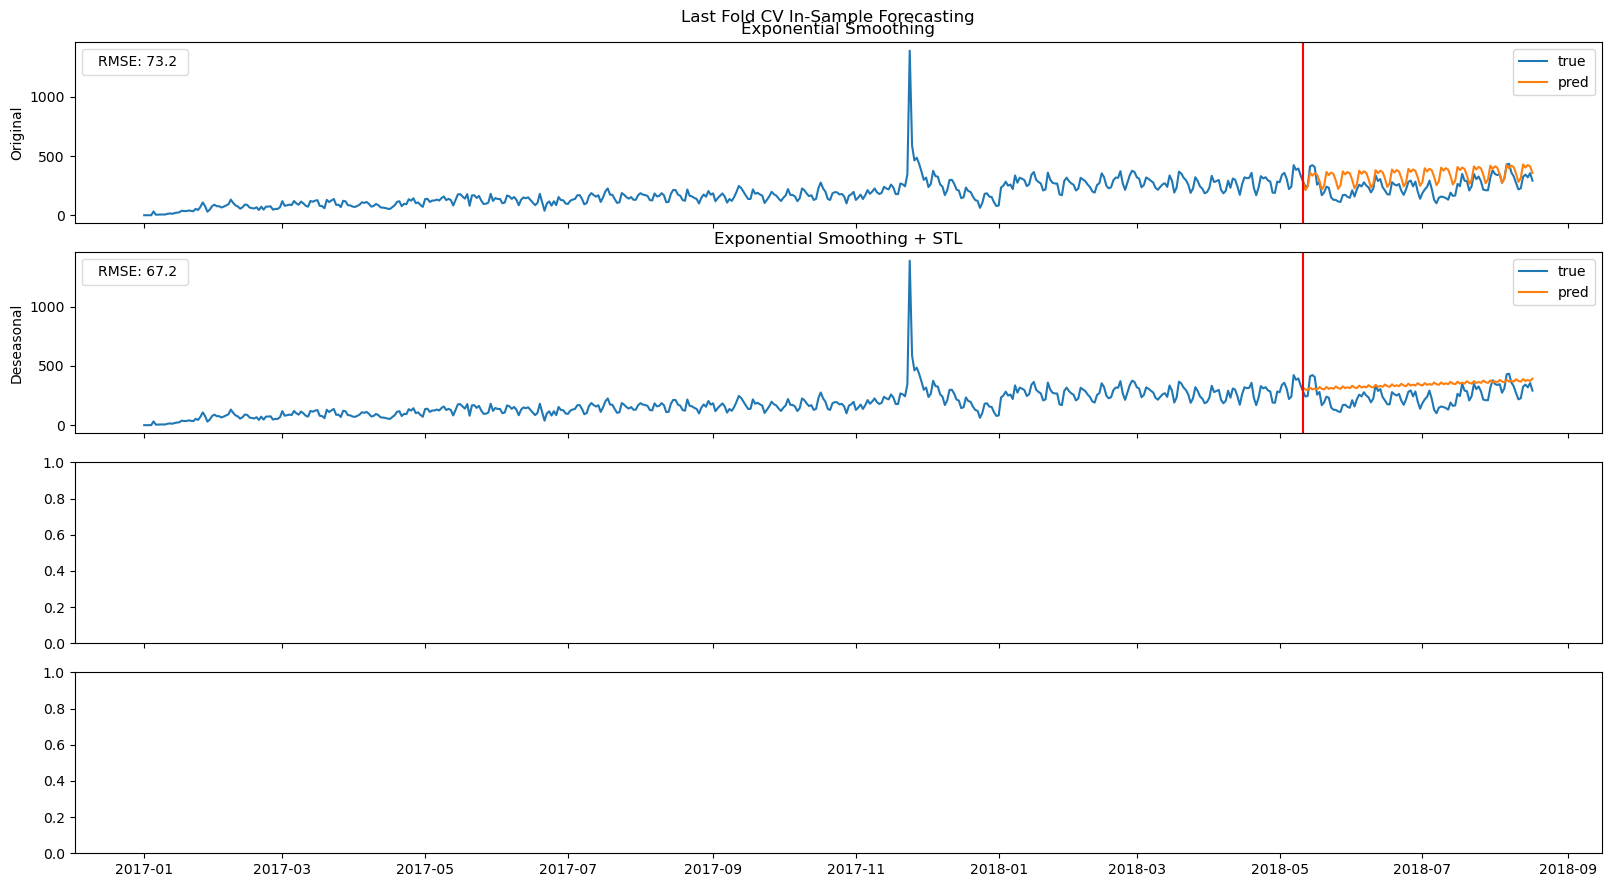

In [42]:
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = ExponentialSmoothing
    model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=7)
    fit_kwargs = dict(smoothing_level=0, smoothing_trend=0.3, smoothing_seasonal=0.4, method='ls')
    stlf = STLForecast(train, ES, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
    pred = stlf.forecast(test.shape[0])
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[1])

In [43]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo       rmse  smape_pct
0                  Time-Series Regression  89.229542  30.749100
1            Time-Series Regression + STL  77.199685  27.672147
2         Time-Series Regression + Boxcox  88.674419  31.035474
3  Time-Series Regression + Seasonal Diff  90.438505  28.289077
4                   Exponential Smoothing  73.152984  21.895807
5             Exponential Smoothing + STL  67.175504  21.363917

## 2C. Exponential Smoothing + Boxcox

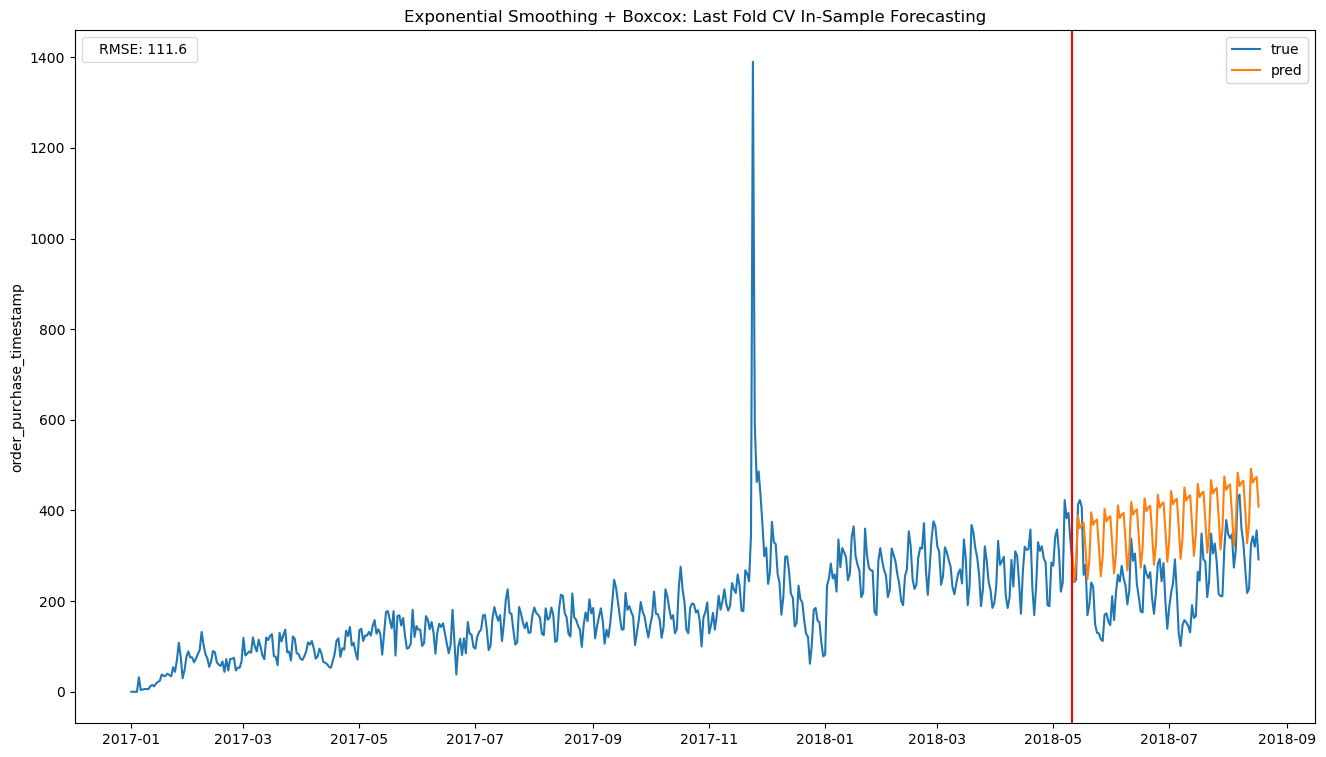

In [44]:
title = 'Exponential Smoothing + Boxcox'
data = bc_history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = (
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
        .fit(method='ls')
    )
    pred = ES.forecast(test.shape[0])
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Searching on the best Parameters

In [45]:
def gscv(alpha, beta, gamma):
    global bc_history
    data = bc_history.copy()
    rmse = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        ES = (
            ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
            .fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls')
        )
        pred = ES.forecast(test.shape[0])
        pred = inv_boxcox1p(pred, lmbda)
        test = inv_boxcox1p(test, lmbda)
        try:
            rmse.append(np.sqrt(mean_squared_error(test, pred)))
        except ValueError:
            return np.nan
    return np.mean(rmse)

alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning

alpha  beta  gamma
0      0.0   0.0    0.0
1      0.0   0.0    0.1
2      0.0   0.0    0.2
3      0.0   0.0    0.3
4      0.0   0.0    0.4
..     ...   ...    ...
995    0.9   0.9    0.5
996    0.9   0.9    0.6
997    0.9   0.9    0.7
998    0.9   0.9    0.8
999    0.9   0.9    0.9

[1000 rows x 3 columns]

In [46]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.alpha, x.beta, x.gamma), axis=1)

Wall time: 22 s


In [47]:
tuning.query('rmse == rmse.min()')

alpha  beta  gamma       rmse
4    0.0   0.0    0.4  73.591691

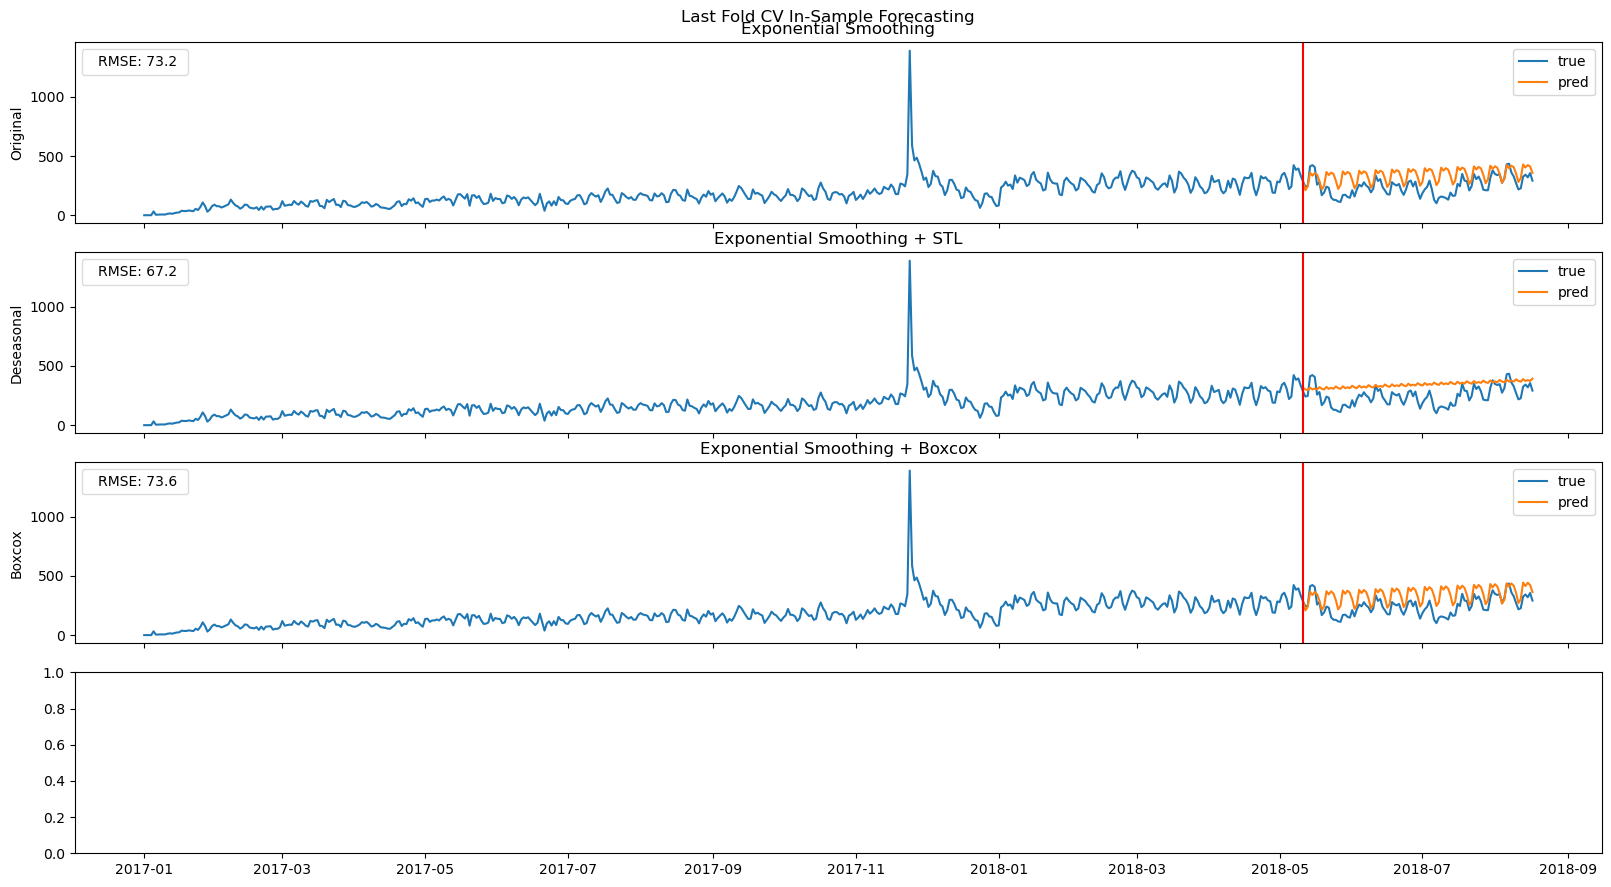

In [48]:
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = (
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
        .fit(smoothing_level=0, smoothing_trend=0, smoothing_seasonal=0.4, method='ls')
    )
    pred = ES.forecast(test.shape[0])
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[2])

In [49]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo       rmse  smape_pct
0                  Time-Series Regression  89.229542  30.749100
1            Time-Series Regression + STL  77.199685  27.672147
2         Time-Series Regression + Boxcox  88.674419  31.035474
3  Time-Series Regression + Seasonal Diff  90.438505  28.289077
4                   Exponential Smoothing  73.152984  21.895807
5             Exponential Smoothing + STL  67.175504  21.363917
6          Exponential Smoothing + Boxcox  73.591691  21.740791

## 2D. Exponential Smoothing + Seasonal Diff

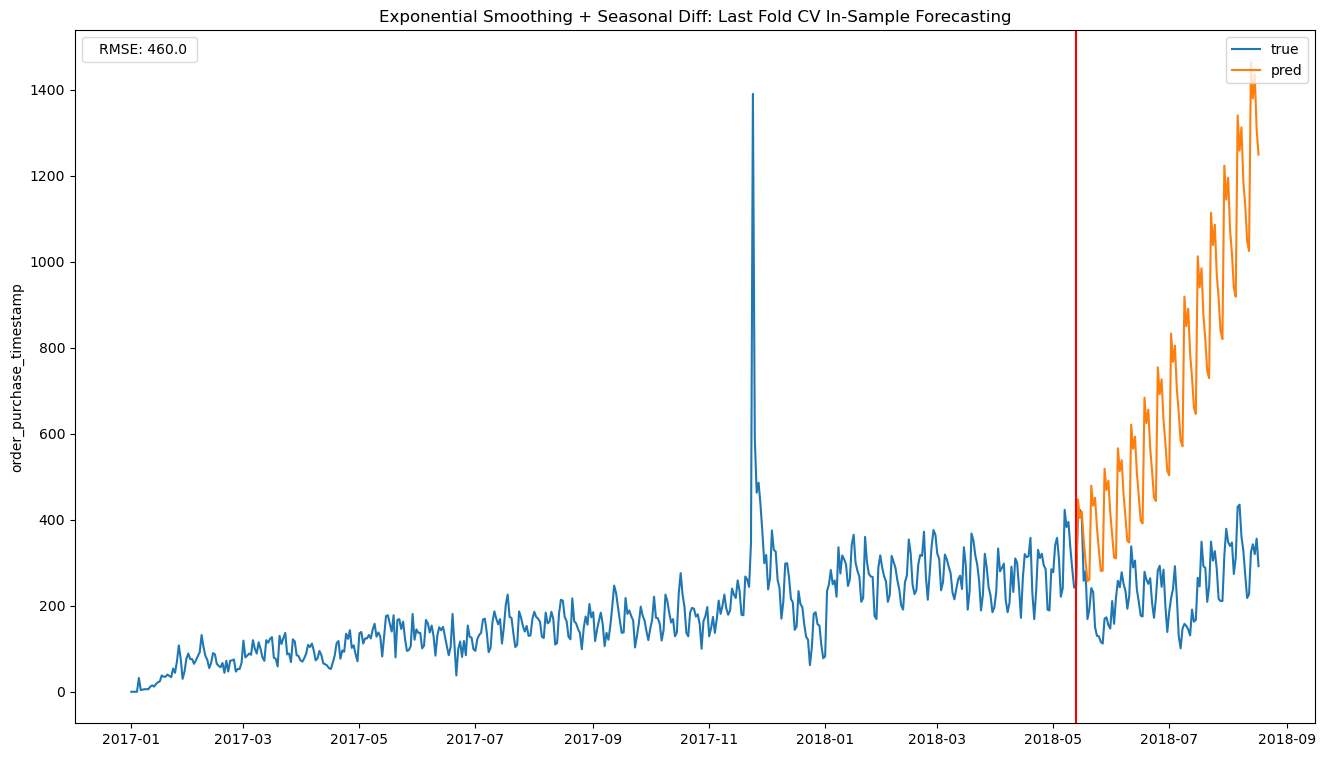

In [50]:
title = 'Exponential Smoothing + Seasonal Diff'
data = diff_history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = (
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
        .fit(method='ls')
    )
    pred = ES.forecast(test.shape[0])
    xi = history.reindex_like(train).tail(N_FEATURES)
    pred = diff_inv_fix(pred, xi).iloc[N_FEATURES:]
    test = diff_inv_fix(test, xi).iloc[N_FEATURES:]
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Searching on the best Parameters

In [51]:
def gscv(alpha, beta, gamma):
    global diff_history
    data = diff_history.copy()
    mse = []
    smape_pct = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        ES = (
            ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
            .fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls')
        )
        pred = ES.forecast(test.shape[0])
        xi = history.reindex_like(train).tail(N_FEATURES)
        pred = diff_inv_fix(pred, xi).iloc[N_FEATURES:]
        test = diff_inv_fix(test, xi).iloc[N_FEATURES:]
        rmse.append(np.sqrt(mean_squared_error(test, pred)))
        smape_pct.append(smape(test, pred))
    return np.mean(rmse)

alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning

alpha  beta  gamma
0      0.0   0.0    0.0
1      0.0   0.0    0.1
2      0.0   0.0    0.2
3      0.0   0.0    0.3
4      0.0   0.0    0.4
..     ...   ...    ...
995    0.9   0.9    0.5
996    0.9   0.9    0.6
997    0.9   0.9    0.7
998    0.9   0.9    0.8
999    0.9   0.9    0.9

[1000 rows x 3 columns]

In [52]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.alpha, x.beta, x.gamma), axis=1)

Wall time: 39.2 s


In [53]:
tuning.query('rmse == rmse.min()')

alpha  beta  gamma        rmse
5    0.0   0.0    0.5  393.702848

<a id="res_es"></a>

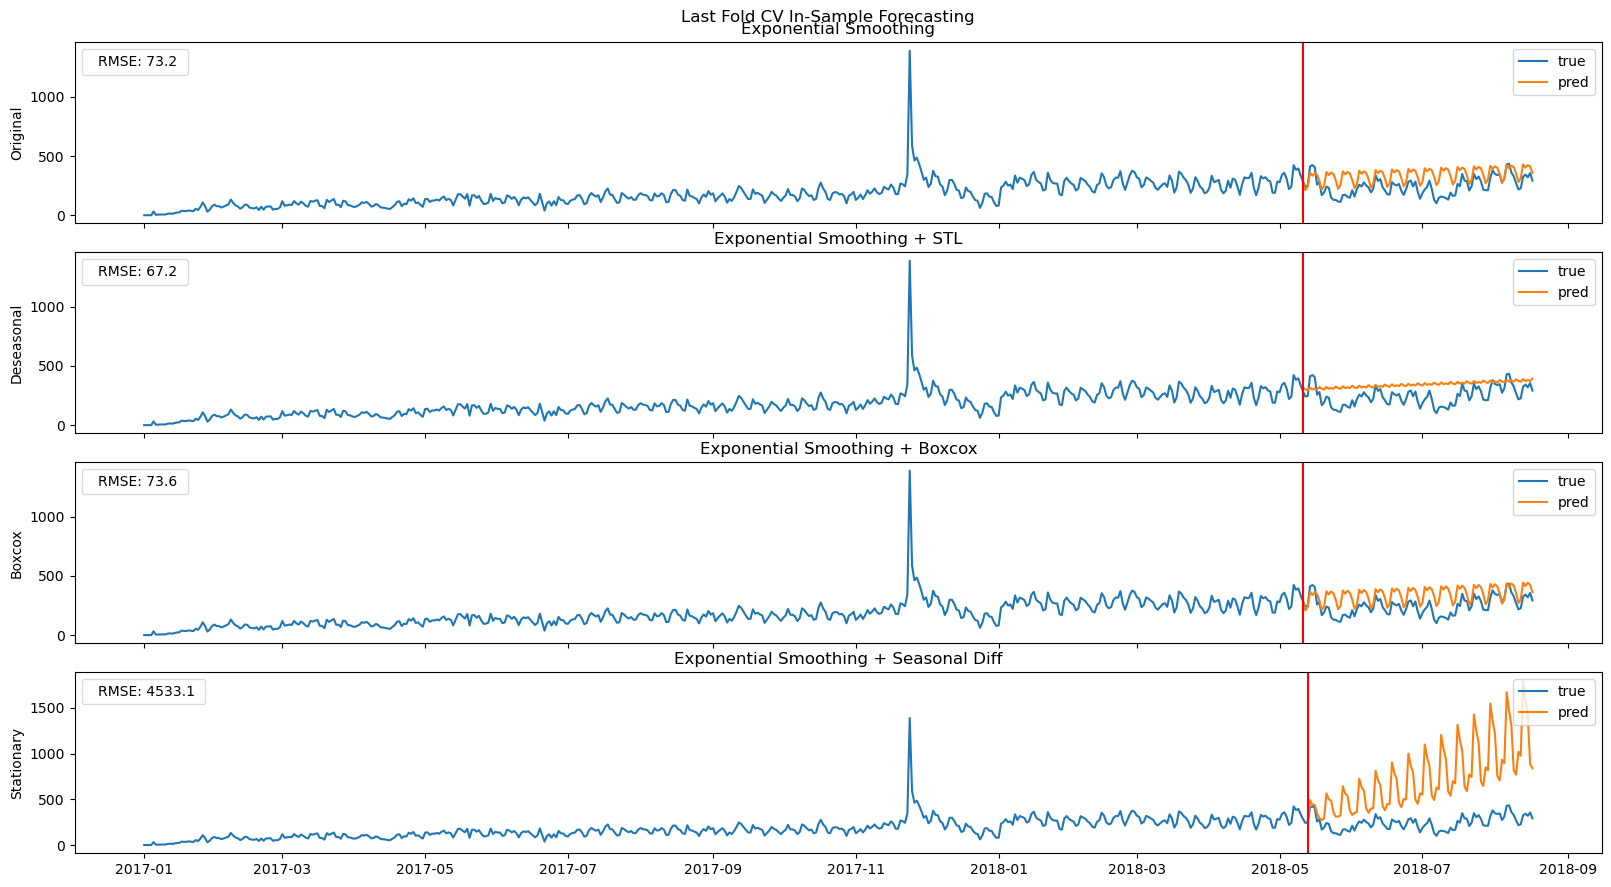

In [54]:
mse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = (
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
        .fit(smoothing_level=0, smoothing_trend=0, smoothing_seasonal=0.5, method='ls')
    )
    pred = ES.forecast(test.shape[0])
    xi = history.reindex_like(train).tail(N_FEATURES)
    pred = diff_inv_fix(pred, xi).iloc[N_FEATURES:]
    test = diff_inv_fix(test, xi).iloc[N_FEATURES:]
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[3])

In [55]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                  Time-Series Regression    89.229542   30.749100
1            Time-Series Regression + STL    77.199685   27.672147
2         Time-Series Regression + Boxcox    88.674419   31.035474
3  Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                   Exponential Smoothing    73.152984   21.895807
5             Exponential Smoothing + STL    67.175504   21.363917
6          Exponential Smoothing + Boxcox    73.591691   21.740791
7   Exponential Smoothing + Seasonal Diff  4533.139192  107.501647

## 3A. (S)ARIMA

<u>`ARIMA (auto-regressive integrated moving average)`</u> models aim to describe the auto-correlations in the time series data. When planning short-term forecasts, ARIMA can make accurate predictions.
<u>`SARIMA (Seasonal Autoregressive Integrated Moving Average)`</u> models are the extension of the ARIMA model that supports uni-variate time series data involving backshifts of the seasonal period.

In [56]:
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(16,9))
figs.suptitle('Last Fold CV In-Sample Forecasting')
figs.align_ylabels()
figs.tight_layout()
plt.close()

### Correlograms (ACF & PACF)
To spot those outside of the blue shade

C:\Users\yuner\anaconda3\envs\capstoneenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


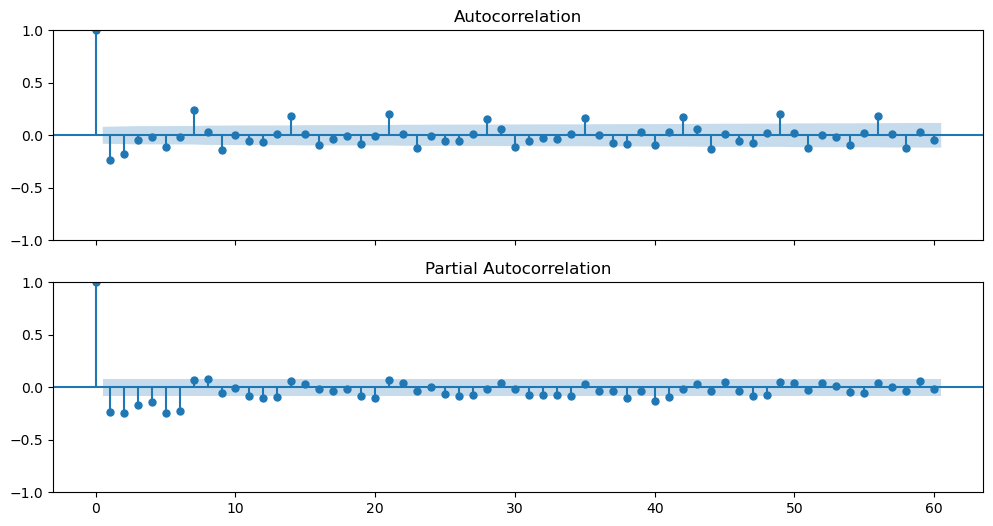

In [57]:
fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True)
plot_acf(history.diff().dropna(), ax=ax[0], lags=60)
plot_pacf(history.diff().dropna(), ax=ax[1], lags=60)
plt.show()

auto-ARIMA returns and selects the best model with the minimum value of the Akaike Information Criterion (AIC) from all the admissible models. 

In [58]:
%%time
data = history.copy()
aa = auto_arima(data, start_p=0, start_q=0,start_d=0, start_P=0, start_Q=0,
                max_p=5, max_q=5, max_d=3, seasonal=True, m =7, stepwise=True, suppress_warnings=True,
                error_action='ignore', trace=True, random=True, random_state= SEED)
aa

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6724.653, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6650.276, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6623.220, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6722.683, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=6651.386, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=6614.071, Time=0.46 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=6693.212, Time=0.18 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=6556.844, Time=0.78 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=6563.146, Time=0.39 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=6652.605, Time=0.25 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=0

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 2, 7),
      suppress_warnings=True)

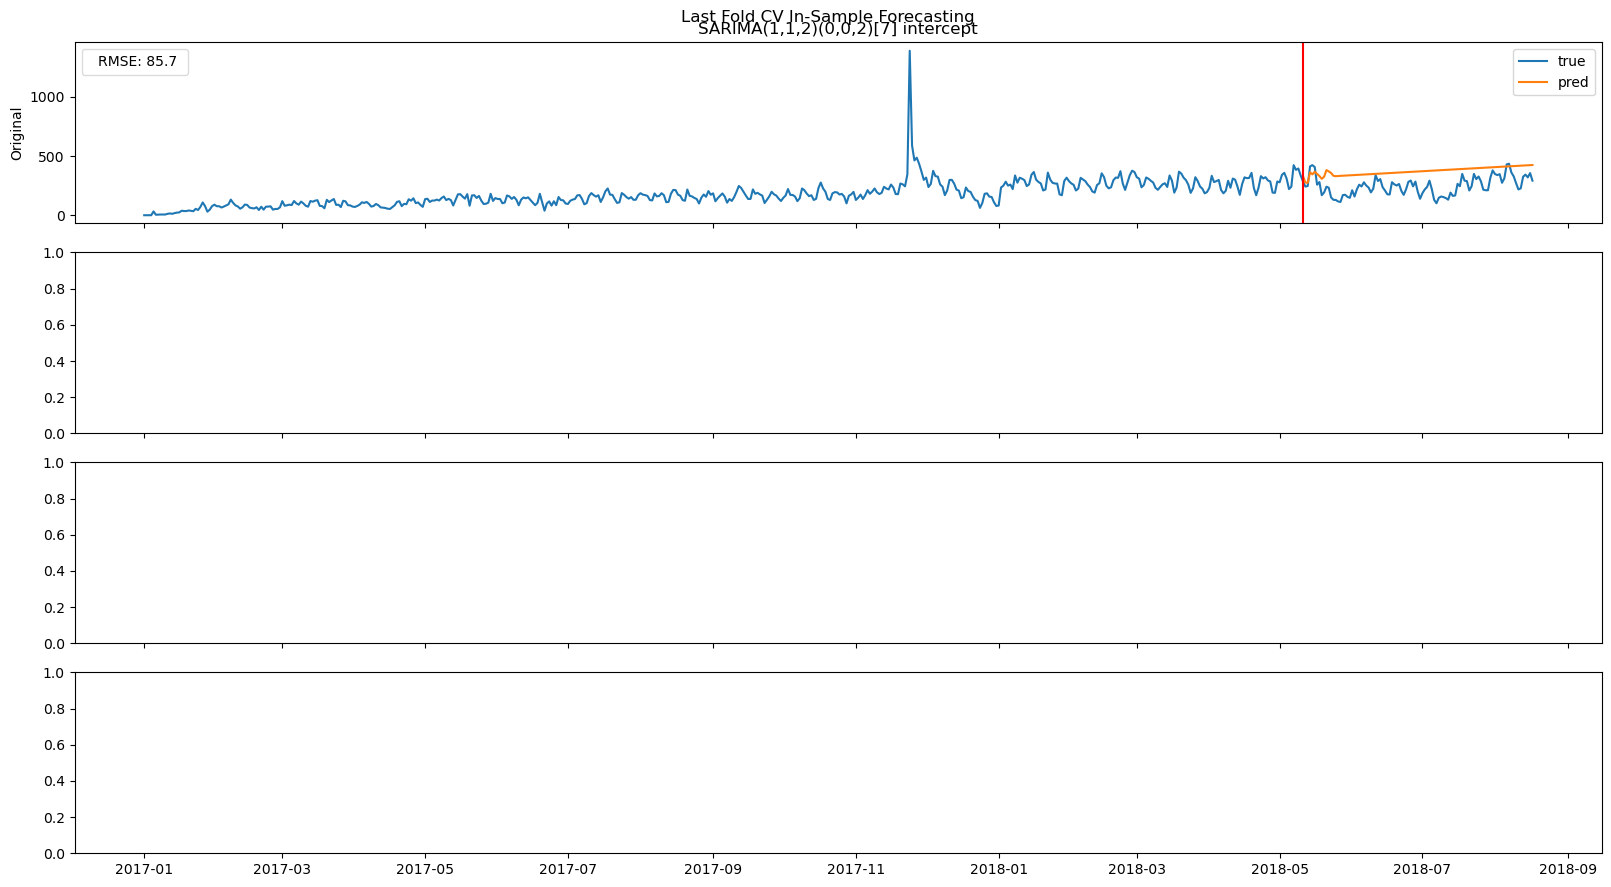

In [59]:
rmse = []
smape_pct = []
if aa.seasonal_order[-1] == 0:
    title = f'ARIMA{aa.order}'
else:
    title = 'S' + aa.__str__().strip()
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    aa.fit(train)
    pred = aa.predict(test.shape[0])
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[0])

In [60]:
if aa.seasonal_order[-1] == 0:
    record(algo='Auto ARIMA', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))
else:
    record(algo='SARIMA', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                  Time-Series Regression    89.229542   30.749100
1            Time-Series Regression + STL    77.199685   27.672147
2         Time-Series Regression + Boxcox    88.674419   31.035474
3  Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                   Exponential Smoothing    73.152984   21.895807
5             Exponential Smoothing + STL    67.175504   21.363917
6          Exponential Smoothing + Boxcox    73.591691   21.740791
7   Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                  SARIMA    85.651922   27.336142

## 3B. ARIMA + STL
Here we use STL to handle the seasonality and then an ARIMA(2,1,1) to model the deseasonalized data. The forecast automatically adds the seasonal component forecast to the ARIMA forecast.

In [61]:
%%time
data = deseasonal.copy()
aa = auto_arima(data, start_p=0, start_q=0,start_d=0, start_P=0, start_Q=0,
                max_p=5, max_q=5, max_d=3, seasonal=False, m =7, stepwise=True, suppress_warnings=True,
                error_action='ignore', trace=True, random=True, random_state= SEED)
aa

C:\Users\yuner\anaconda3\envs\capstoneenv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6320.503, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6263.013, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6238.000, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6318.567, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6233.875, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6220.515, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6245.333, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6238.579, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6226.935, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6237.093, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6223.571, Time=0.14 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 2.561 seconds
Wall time: 2.57 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

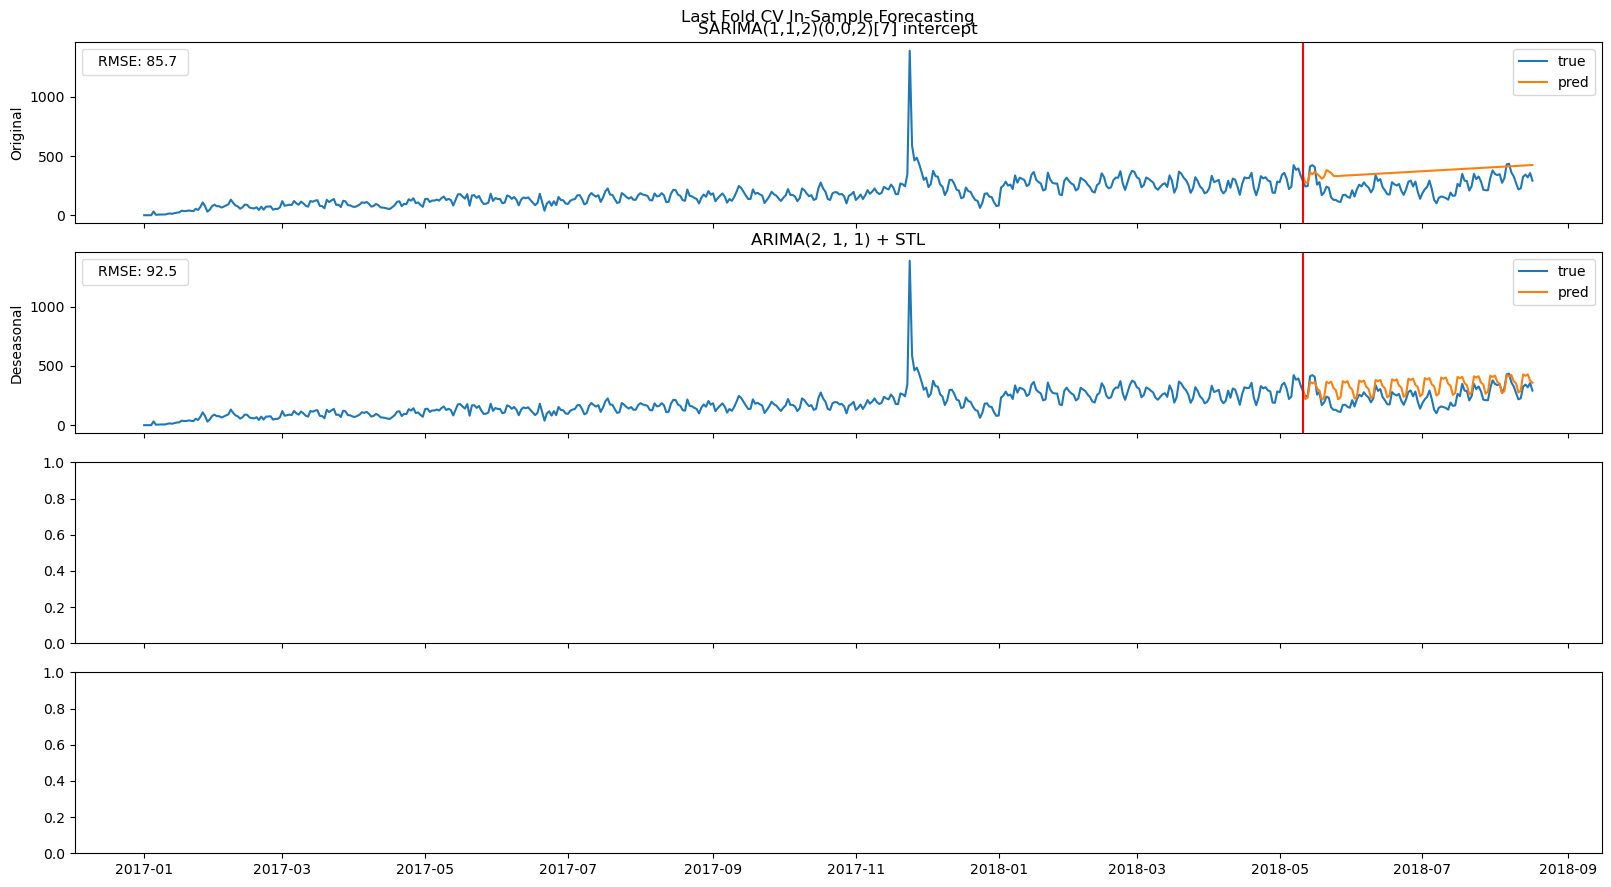

In [62]:
rmse = []
smape_pct = []
if aa.seasonal_order[-1] == 0:
    title = f'ARIMA{aa.order} + STL'
else:
    title = 'S' + aa.__str__().strip() + ' + STL'
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    aa.fit(train)
    pred = aa.predict(test.shape[0])
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    pred = pred + np.fromiter(cycle(last_seasonal), count=pred.shape[0], dtype=float)
    test = test + res.seasonal.reindex_like(test)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[1])

In [63]:
if aa.seasonal_order[-1] == 0:
    record(algo='Auto ARIMA + STL', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))
else:
    record(algo='SARIMA + STL', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                  Time-Series Regression    89.229542   30.749100
1            Time-Series Regression + STL    77.199685   27.672147
2         Time-Series Regression + Boxcox    88.674419   31.035474
3  Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                   Exponential Smoothing    73.152984   21.895807
5             Exponential Smoothing + STL    67.175504   21.363917
6          Exponential Smoothing + Boxcox    73.591691   21.740791
7   Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                  SARIMA    85.651922   27.336142
9                        Auto ARIMA + STL    92.520916   28.986918

## 3C. (S)ARIMA + Boxcox

In [64]:
%%time
data = bc_history.copy()
aa = auto_arima(data, start_p=0, start_q=0,start_d=0, start_P=0, start_Q=0,
                max_p=5, max_q=5, max_d=3, seasonal=True, m =7, stepwise=True, suppress_warnings=True,
                error_action='ignore', trace=True, random=True, random_state= SEED)
aa

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3475.807, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3365.920, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3380.570, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3473.923, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3467.318, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=3339.578, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=3248.682, Time=0.38 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=3397.695, Time=0.12 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=3379.834, Time=0.20 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.09 s

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(2, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

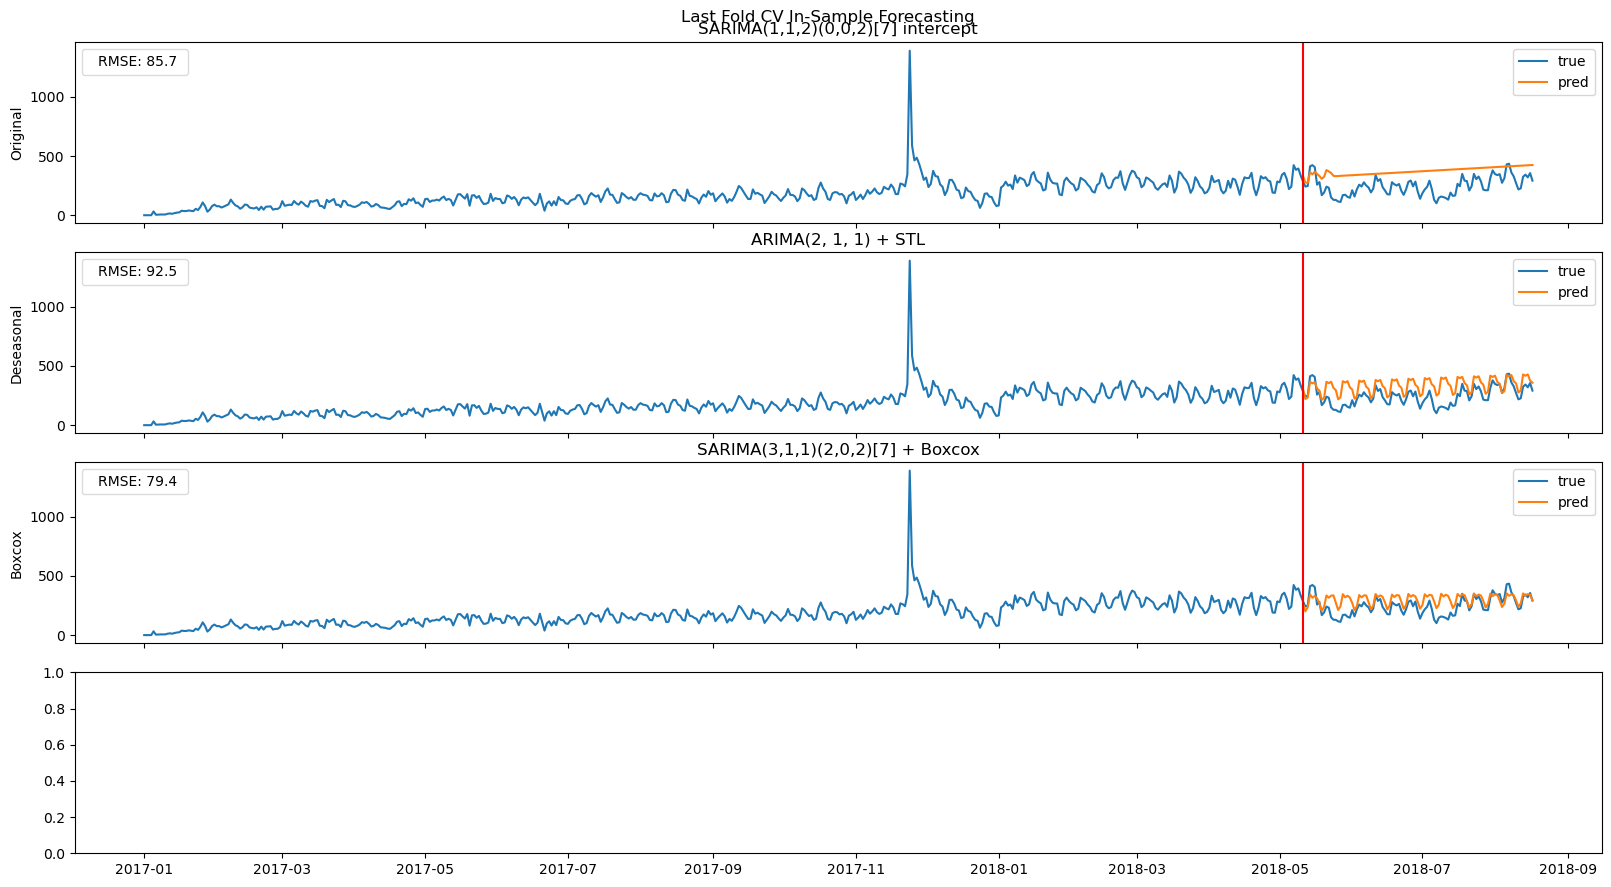

In [65]:
rmse = []
smape_pct = []
if aa.seasonal_order[-1] == 0:
    title = f'ARIMA{aa.order} + Boxcox'
else:
    title = 'S' + aa.__str__().strip() + ' + Boxcox'
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    aa.fit(train)
    pred = aa.predict(test.shape[0])
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[2])

In [66]:
if aa.seasonal_order[-1] == 0:
    record(algo='Auto ARIMA + BOXCOX', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))
else:
    record(algo='SARIMA + BOXCOX', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                   Time-Series Regression    89.229542   30.749100
1             Time-Series Regression + STL    77.199685   27.672147
2          Time-Series Regression + Boxcox    88.674419   31.035474
3   Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                    Exponential Smoothing    73.152984   21.895807
5              Exponential Smoothing + STL    67.175504   21.363917
6           Exponential Smoothing + Boxcox    73.591691   21.740791
7    Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                   SARIMA    85.651922   27.336142
9                         Auto ARIMA + STL    92.520916   28.986918
10                         SARIMA + BOXCOX    79.424015   26.597737

## 3D. ARIMA + Seasonal Diff

In [67]:
%%time
data = diff_history.copy()
aa = auto_arima(data, start_p=0, start_q=0,start_d=0, start_P=0, start_Q=0,
                max_p=5, max_q=5, max_d=3, seasonal=False, m =7, stepwise=True, suppress_warnings=True,
                error_action='ignore', trace=True, random=True, random_state= SEED)
aa

C:\Users\yuner\anaconda3\envs\capstoneenv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6904.755, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6738.303, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6784.822, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6735.615, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6737.486, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6737.495, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6735.519, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6737.489, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6752.120, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6729.816, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6717.146, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6739.482, Time=0.12 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=6717.137, Time=0.70 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6726.641, Time=0.38 sec
 ARIMA(5,0,2)(0,0,0)[0]          

ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

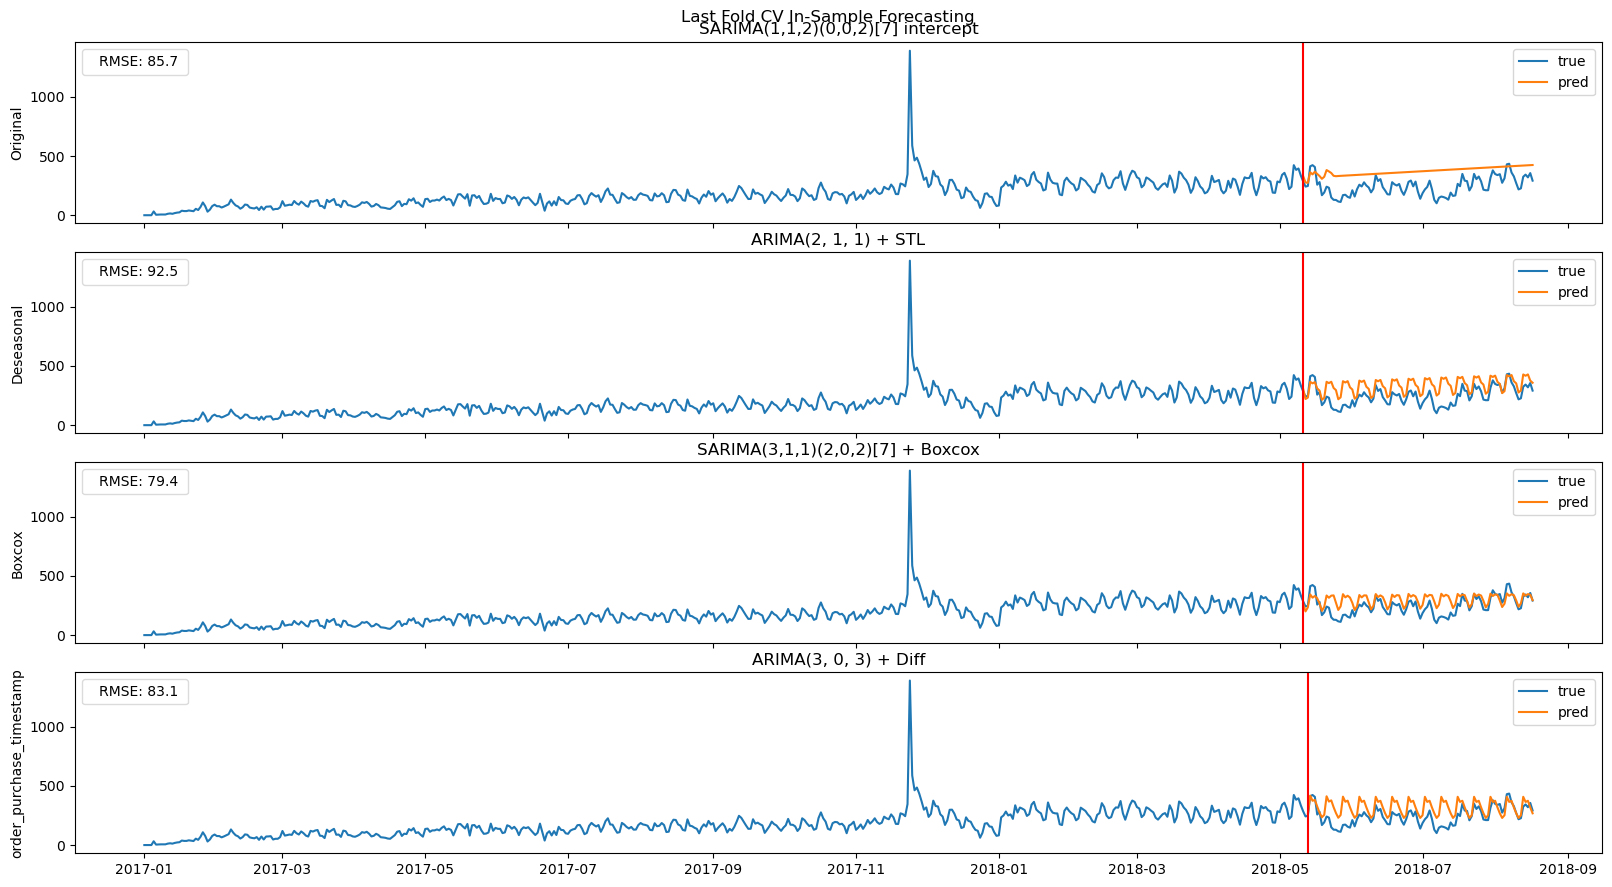

In [68]:
rmse = []
smape_pct = []
if aa.seasonal_order[-1] == 0:
    title = f'ARIMA{aa.order} + Diff'
else:
    title = 'S' + aa.__str__().strip() + ' + Diff'
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    aa.fit(train)
    pred = aa.predict(test.shape[0])
    xi = history.reindex_like(train).tail(N_FEATURES)
    pred = diff_inv_fix(pred, xi).iloc[N_FEATURES:]
    test = diff_inv_fix(test, xi).iloc[N_FEATURES:]
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[3])

In [69]:
if aa.seasonal_order[-1] == 0:
    record(algo='Auto ARIMA + Seasonal Diff', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))
else:
    record(algo='SARIMA + Seasonal Diff', rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                   Time-Series Regression    89.229542   30.749100
1             Time-Series Regression + STL    77.199685   27.672147
2          Time-Series Regression + Boxcox    88.674419   31.035474
3   Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                    Exponential Smoothing    73.152984   21.895807
5              Exponential Smoothing + STL    67.175504   21.363917
6           Exponential Smoothing + Boxcox    73.591691   21.740791
7    Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                   SARIMA    85.651922   27.336142
9                         Auto ARIMA + STL    92.520916   28.986918
10                         SARIMA + BOXCOX    79.424015   26.597737
11              Auto ARIMA + Seasonal Diff    83.124392   31.926240

## 4A. LSTM

LSTMs are a special form of a recurrent neural network (RNN). In LSTM model, the long sequence of data is remembered or stored by incorporating a gating mechanism. This gating mechanism uses some information from previous steps to produce output by evaluating a function. This output is used to modify the current LSTM cell state. There are three gate structures in LSTM cell; input gates, output gates, and forget gates, and the structure of an LSTM cell is shown `below`.
![](../assets/fig-1_LSTM.png)

The advantage of neural network(NN) models is that they can effectively handle non-linear relationships.

In order to use LSTM models on time series data, data should be transformed into a structure of samples with input and output components. Keras deep learning library provides the TimeseriesGenerator to automatically transform time series data into samples. TimeseriesGenerator uses the length parameter in order to define the sample length used to train the model. This parameter as used for predicting the next value after sample input which has (length) number of elements.

In [70]:
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(16, 9))
figs.suptitle('Last Fold CV In-Sample Forecasting')
figs.align_ylabels()
figs.tight_layout()
plt.close()

In [71]:
def reset_random_seeds():
    global SEED
    os.environ['PYTHONHASHSEED']=str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

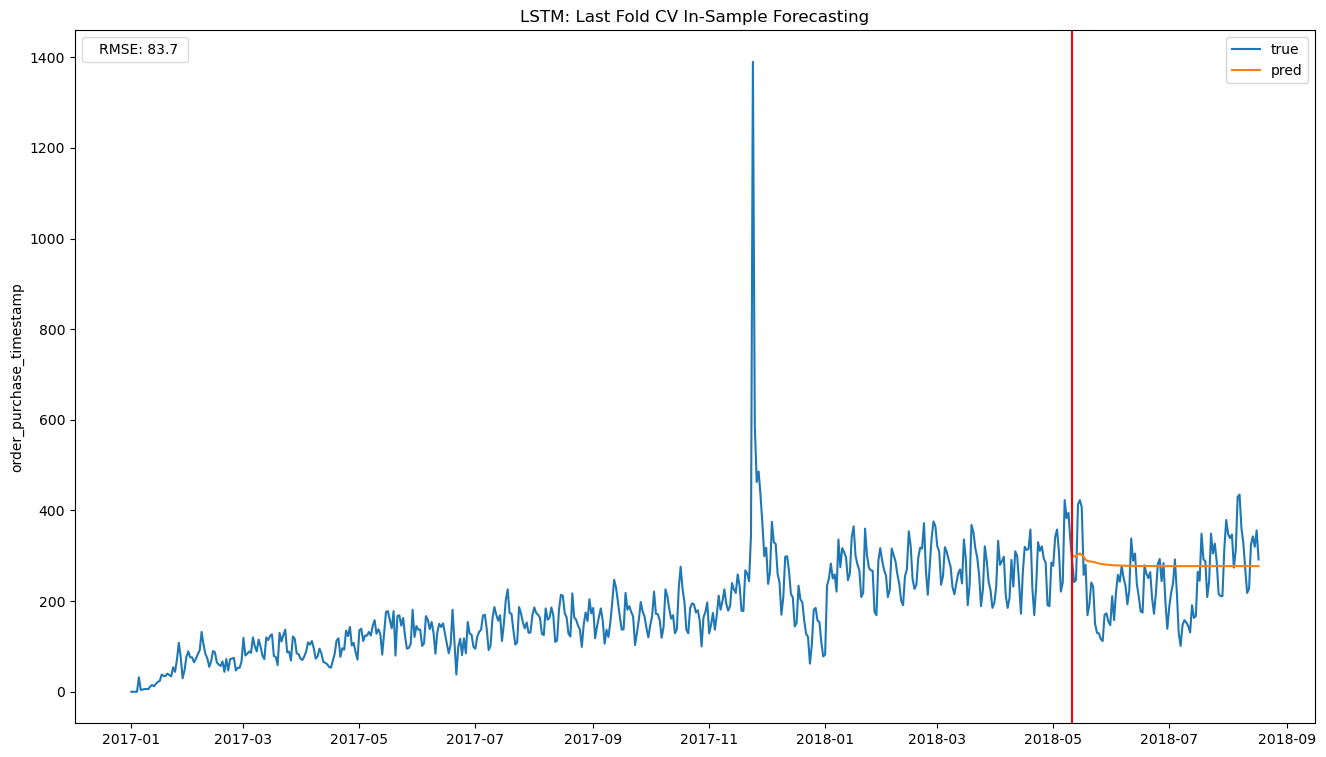

In [72]:
title = 'LSTM'
data = history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    reset_random_seeds()
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Search on best learning rate

In [73]:
def gscv(learning_rate):
    rmse = []
    smape_pct = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        ss = StandardScaler()
        ss.fit(train.values.reshape(-1,1))
        train_input = ss.transform(train.values.reshape(-1,1))

        # First test set prediction using 7 inputs and 1 label: total 8 observations
        test_input = train_input[-(N_FEATURES+1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

        clear_session()
        reset_random_seeds()
        model = Sequential()
        model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
        model.add(Dense(1, kernel_initializer='zeros'))

        early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
        h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
        pred = np.empty(test.shape[0])
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose=False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
            test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        rmse.append(np.sqrt(mean_squared_error(test, pred)))
        smape_pct.append(smape(test, pred))
    return np.mean(rmse)

learning_rates = np.logspace(-3, 1, 5)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning

learning_rate
0          0.001
1          0.010
2          0.100
3          1.000
4         10.000

In [74]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.learning_rate), axis=1)

Wall time: 3min 13s


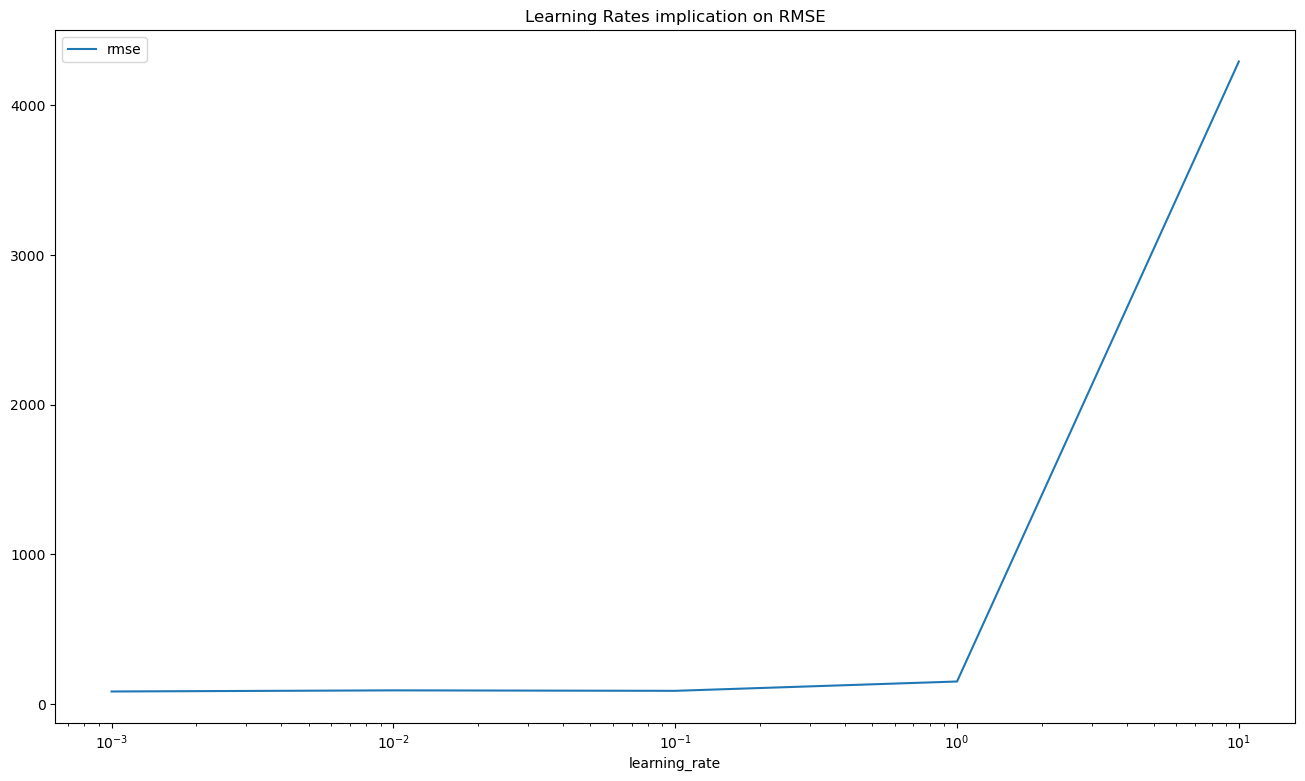

In [75]:
fig, ax = plt.subplots(figsize=(16, 9))
ax = tuning.plot(x='learning_rate', y='rmse', ax=ax)
ax.set_xscale('log')
ax.set_title('Learning Rates implication on RMSE')
plt.show()

In [76]:
tuning.query('rmse == rmse.min()')

learning_rate       rmse
0          0.001  83.734142

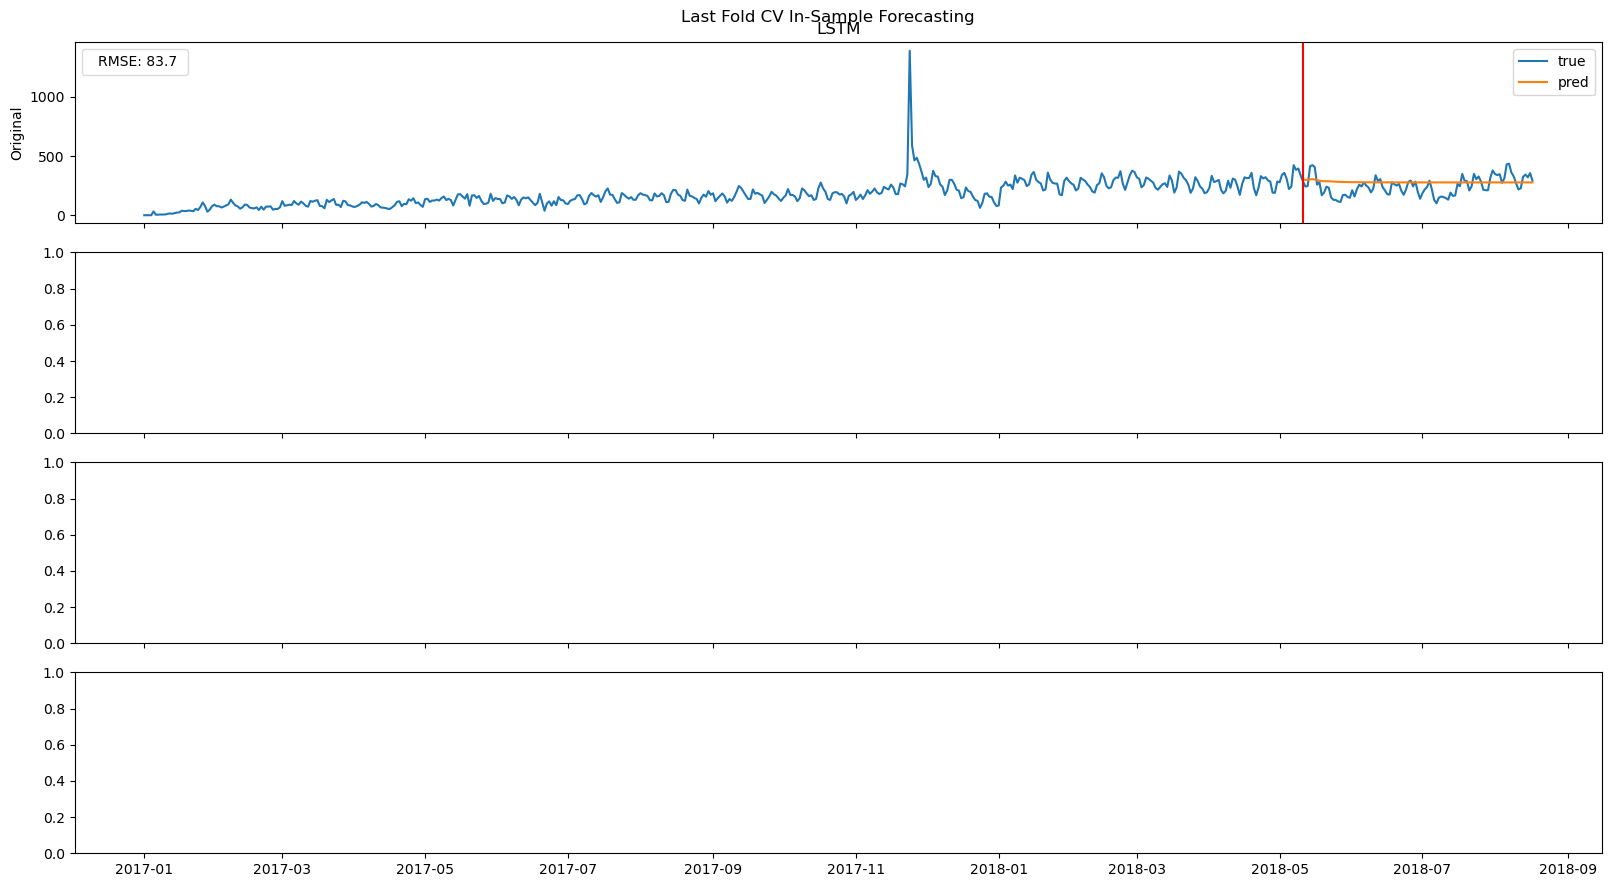

In [77]:
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    reset_random_seeds()
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[0])

In [78]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                   Time-Series Regression    89.229542   30.749100
1             Time-Series Regression + STL    77.199685   27.672147
2          Time-Series Regression + Boxcox    88.674419   31.035474
3   Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                    Exponential Smoothing    73.152984   21.895807
5              Exponential Smoothing + STL    67.175504   21.363917
6           Exponential Smoothing + Boxcox    73.591691   21.740791
7    Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                   SARIMA    85.651922   27.336142
9                         Auto ARIMA + STL    92.520916   28.986918
10                         SARIMA + BOXCOX    79.424015   26.597737
11              Auto ARIMA + Seasonal Diff    83.124392   31.926240
12                                    LSTM    83.734142   29.853399

In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


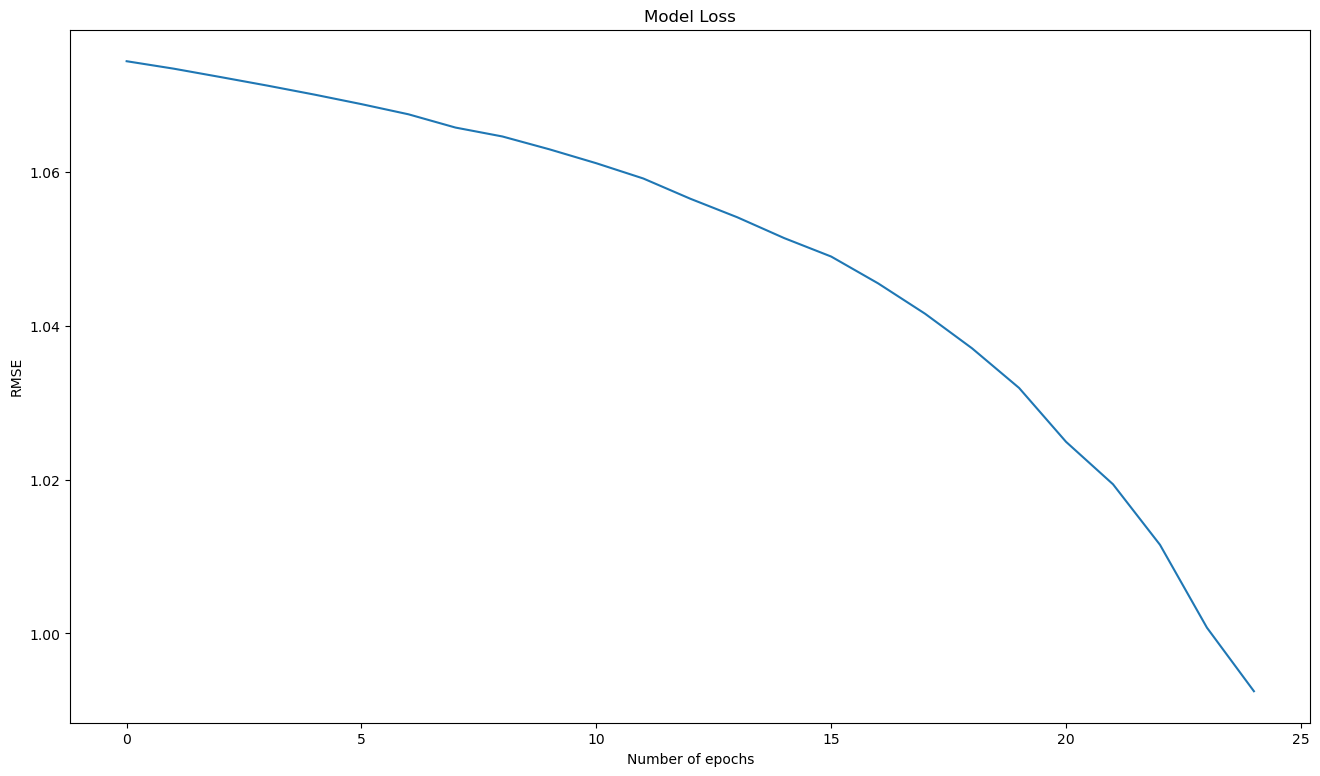

In [80]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x=range(len(h.history['loss'])), y=h.history['loss'], ax=ax)
ax.set_xlabel('Number of epochs')
ax.set_ylabel('RMSE')
ax.set_title('Model Loss')
plt.show()

## 4B. LSTM + STL

Seasonal-trend decomposition based on the Loess (STL) algorithm is applied to the original time series and these decomposed components are used to train our recurrent neural network (RNN) model LSTM for reducing the impact of these irregular patterns on final predictions. The overall training phase is illustrated in figure below.

![](../assets/fig-2_training_steps_LSTM.jpg)

The decomposition algorithm simply extracts these three patterns from original data. The combination of the components in time series can be of two types; additive or multiplicative. In the additive time series, the components of the time series are added together to make the original time series. On the other hand, in the multiplicative time series, the components of the time series are multiplicative together. After decomposition, LSTM model is fitted to trend and residual components to train. Since this model ignores seasonal pattern, the reseasonalization process is applied after the prediction phase. In this process, the relevant seasonal components which are already extracted in decomposition stage are added to the forecasts generated by LSTM model.

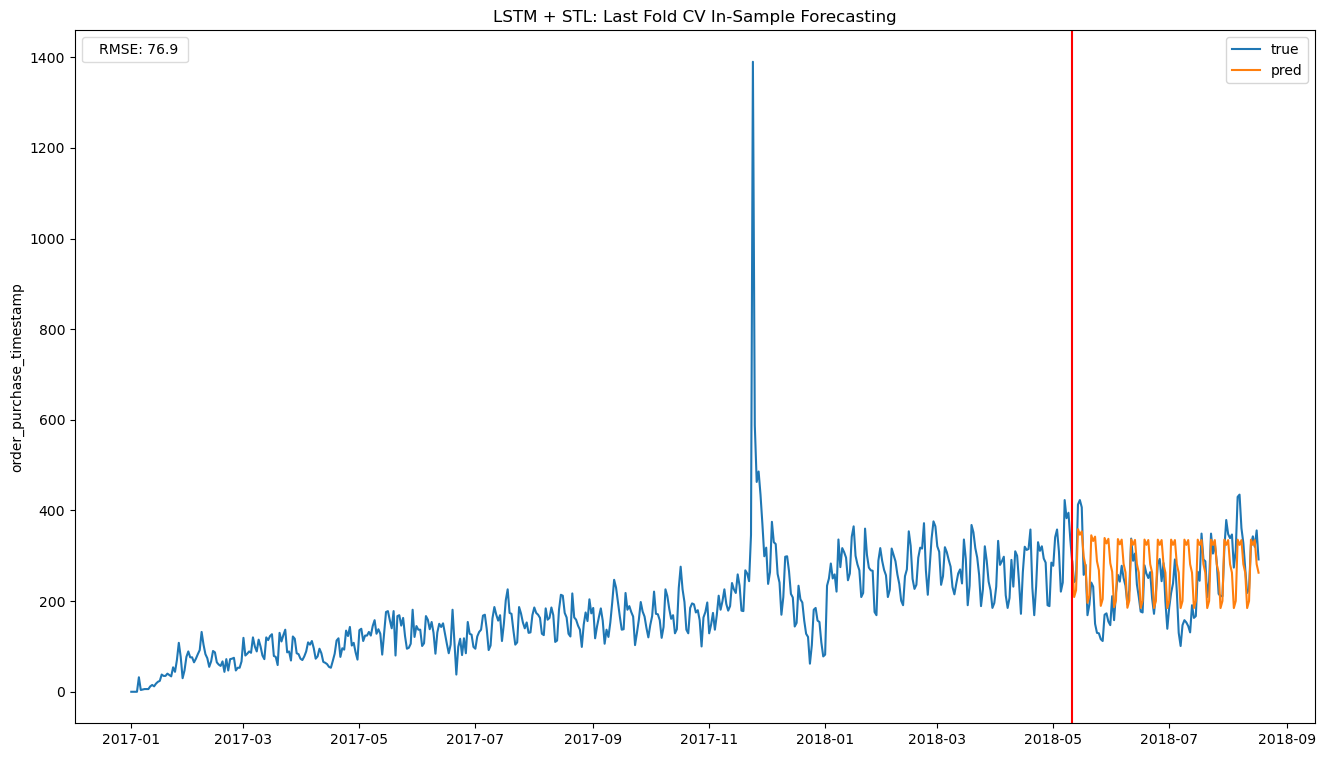

In [81]:
title = 'LSTM + STL'
data = deseasonal.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    reset_random_seeds()
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    pred = pred + np.fromiter(cycle(last_seasonal), count=pred.shape[0], dtype=float)
    test = test + res.seasonal.reindex_like(test)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Search on best learning rate

In [82]:
def gscv(learning_rate):
    global deseasonal
    data = deseasonal.copy()
    rmse = []
    smape_pct = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        ss = StandardScaler()
        ss.fit(train.values.reshape(-1,1))
        train_input = ss.transform(train.values.reshape(-1,1))

        # First test set prediction using 7 inputs and 1 label: total 8 observations
        test_input = train_input[-(N_FEATURES+1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

        clear_session()
        reset_random_seeds()
        model = Sequential()
        model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
        model.add(Dense(1, kernel_initializer='zeros'))

        early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
        h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
        pred = np.empty(test.shape[0])
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose=False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
            test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
        pred = pred + np.fromiter(cycle(last_seasonal), count=pred.shape[0], dtype=float)
        test = test + res.seasonal.reindex_like(test)
        rmse.append(np.sqrt(mean_squared_error(test, pred)))
        smape_pct.append(smape(test, pred))
    return np.mean(rmse)

learning_rates = np.logspace(-3, 1, 5)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning

learning_rate
0          0.001
1          0.010
2          0.100
3          1.000
4         10.000

In [83]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.learning_rate), axis=1)

Wall time: 3min 16s


In [84]:
tuning.query('rmse == rmse.min()')

learning_rate       rmse
0          0.001  76.897281

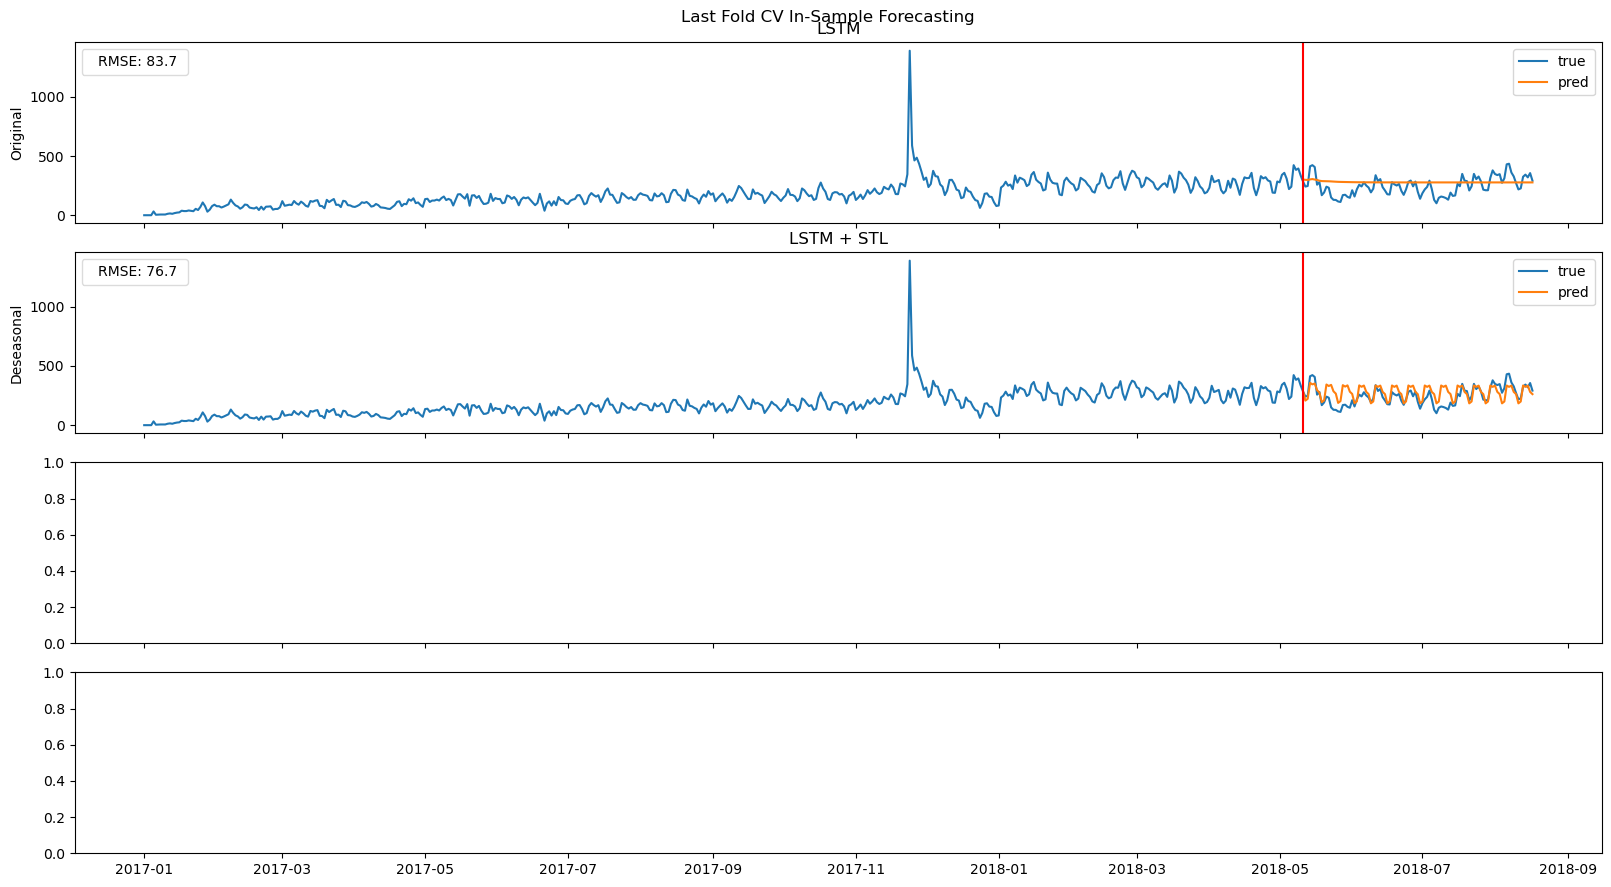

In [85]:
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    tf.random.set_seed(0)
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    pred = pred + np.fromiter(cycle(last_seasonal), count=pred.shape[0], dtype=float)
    test = test + res.seasonal.reindex_like(test)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[1])

In [86]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                   Time-Series Regression    89.229542   30.749100
1             Time-Series Regression + STL    77.199685   27.672147
2          Time-Series Regression + Boxcox    88.674419   31.035474
3   Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                    Exponential Smoothing    73.152984   21.895807
5              Exponential Smoothing + STL    67.175504   21.363917
6           Exponential Smoothing + Boxcox    73.591691   21.740791
7    Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                   SARIMA    85.651922   27.336142
9                         Auto ARIMA + STL    92.520916   28.986918
10                         SARIMA + BOXCOX    79.424015   26.597737
11              Auto ARIMA + Seasonal Diff    83.124392   31.926240
12                                    LSTM    83.734142   29.853399
13                              LSTM + STL    76.732163   27.514312

## 4C. LSTM + Boxcox

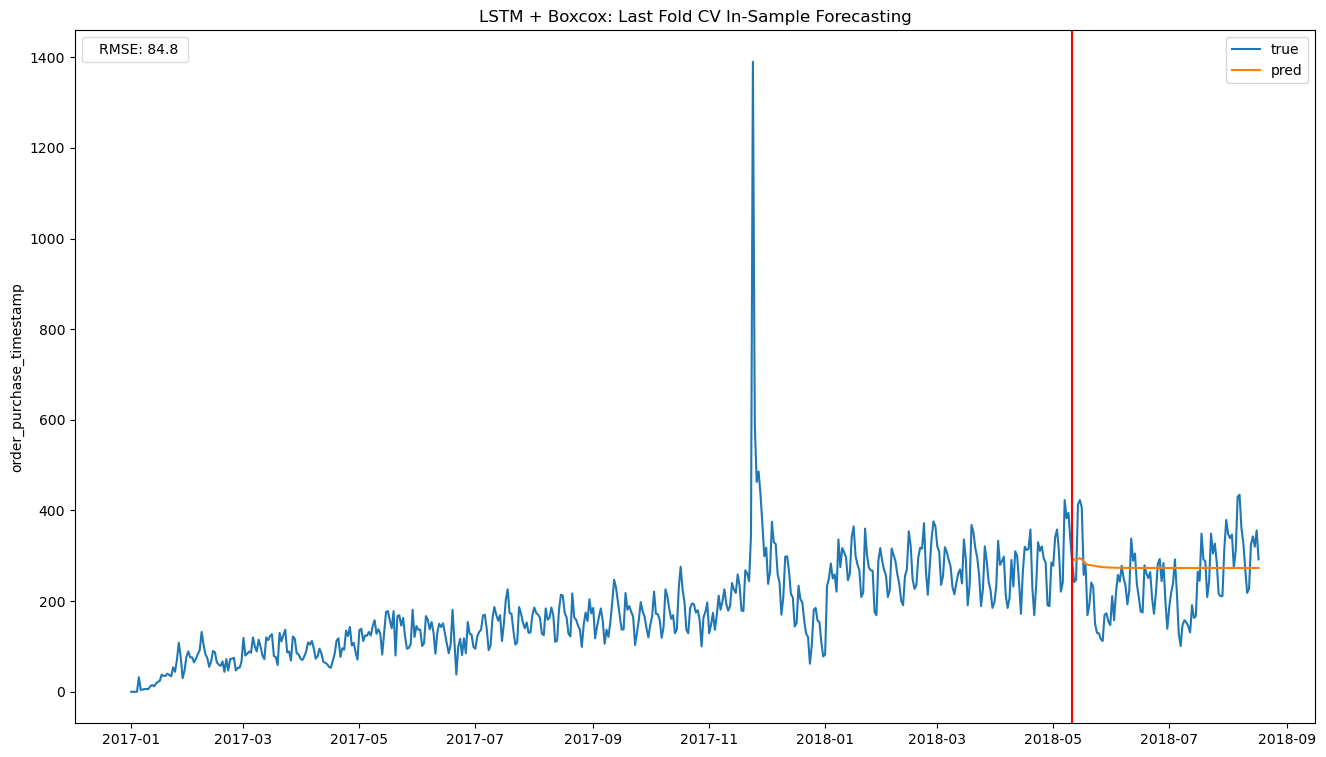

In [87]:
title = 'LSTM + Boxcox'
data = bc_history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    reset_random_seeds()
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Search on best learning rate

In [88]:
def gscv(learning_rate):
    global bc_history
    data = bc_history.copy()
    rmse = []
    smape_pct = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        ss = StandardScaler()
        ss.fit(train.values.reshape(-1,1))
        train_input = ss.transform(train.values.reshape(-1,1))

        # First test set prediction using 7 inputs and 1 label: total 8 observations
        test_input = train_input[-(N_FEATURES+1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

        clear_session()
        reset_random_seeds()
        model = Sequential()
        model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
        model.add(Dense(1, kernel_initializer='zeros'))

        early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
        h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
        pred = np.empty(test.shape[0])
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose=False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
            test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        pred = inv_boxcox1p(pred, lmbda)
        test = inv_boxcox1p(test, lmbda)
        try:
            rmse.append(np.sqrt(mean_squared_error(test, pred)))
            smape_pct.append(smape(test, pred))
        except ValueError:
            return np.nan
    return np.mean(rmse)

learning_rates = np.logspace(-3, 1, 5)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning

learning_rate
0          0.001
1          0.010
2          0.100
3          1.000
4         10.000

In [89]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.learning_rate), axis=1)

Wall time: 2min 58s


In [90]:
tuning.query('rmse == rmse.min()')

learning_rate       rmse
0          0.001  84.833232

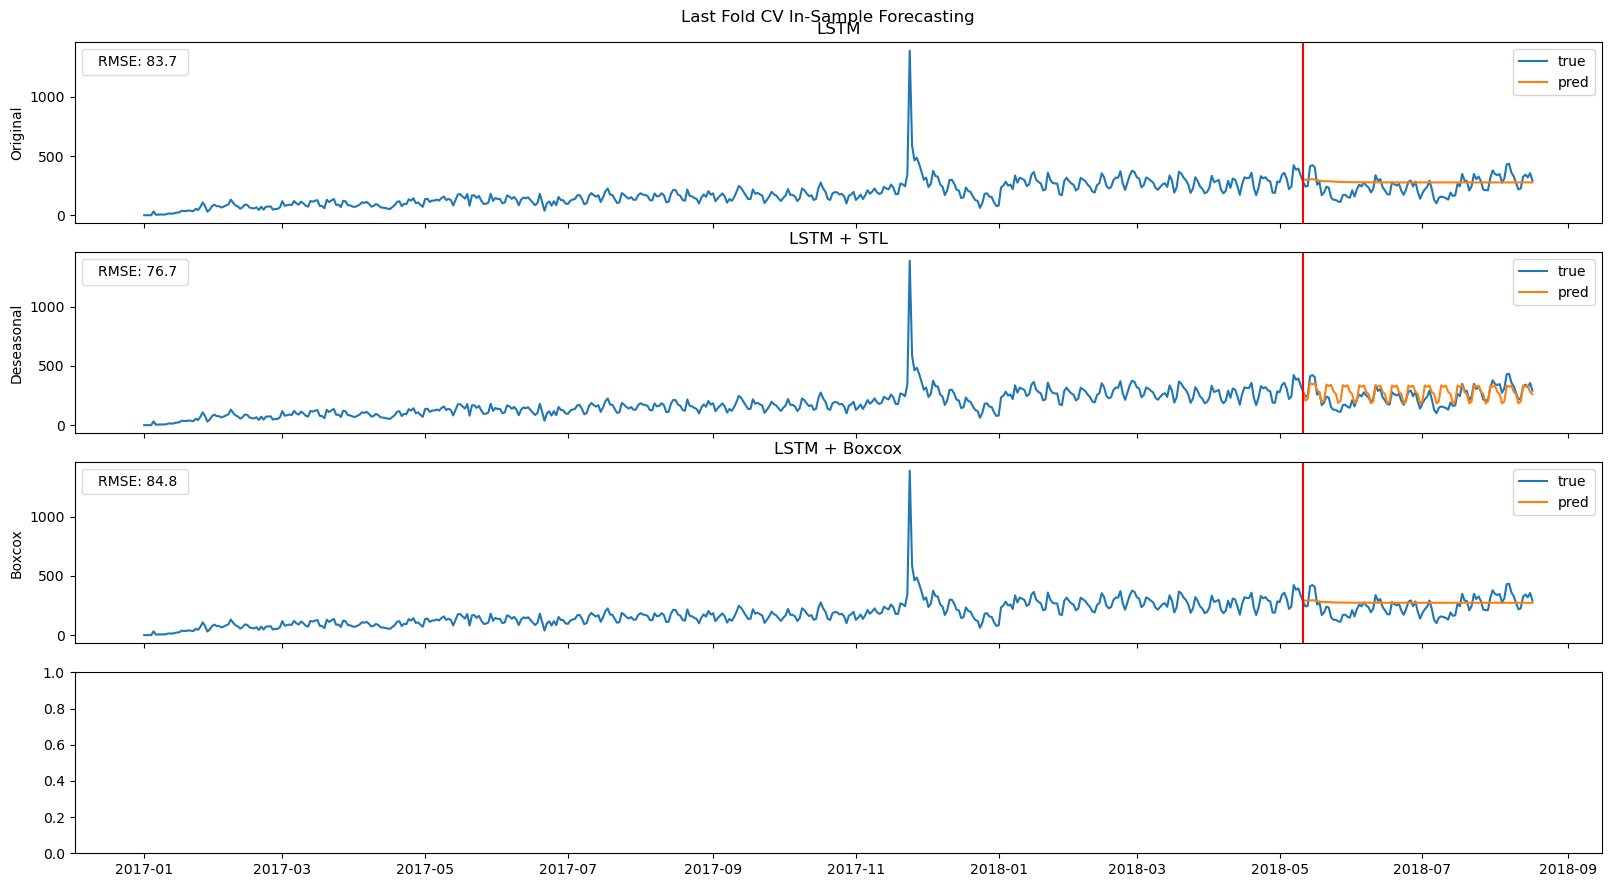

In [91]:
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    reset_random_seeds()
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[2])

In [92]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                   Time-Series Regression    89.229542   30.749100
1             Time-Series Regression + STL    77.199685   27.672147
2          Time-Series Regression + Boxcox    88.674419   31.035474
3   Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                    Exponential Smoothing    73.152984   21.895807
5              Exponential Smoothing + STL    67.175504   21.363917
6           Exponential Smoothing + Boxcox    73.591691   21.740791
7    Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                   SARIMA    85.651922   27.336142
9                         Auto ARIMA + STL    92.520916   28.986918
10                         SARIMA + BOXCOX    79.424015   26.597737
11              Auto ARIMA + Seasonal Diff    83.124392   31.926240
12                                    LSTM    83.734142   29.853399
13                              LSTM + STL    76.732163   27.514312
14                           LSTM + Boxcox    84.833232   30.580378

## 4D. LSTM + Seasonal Diff

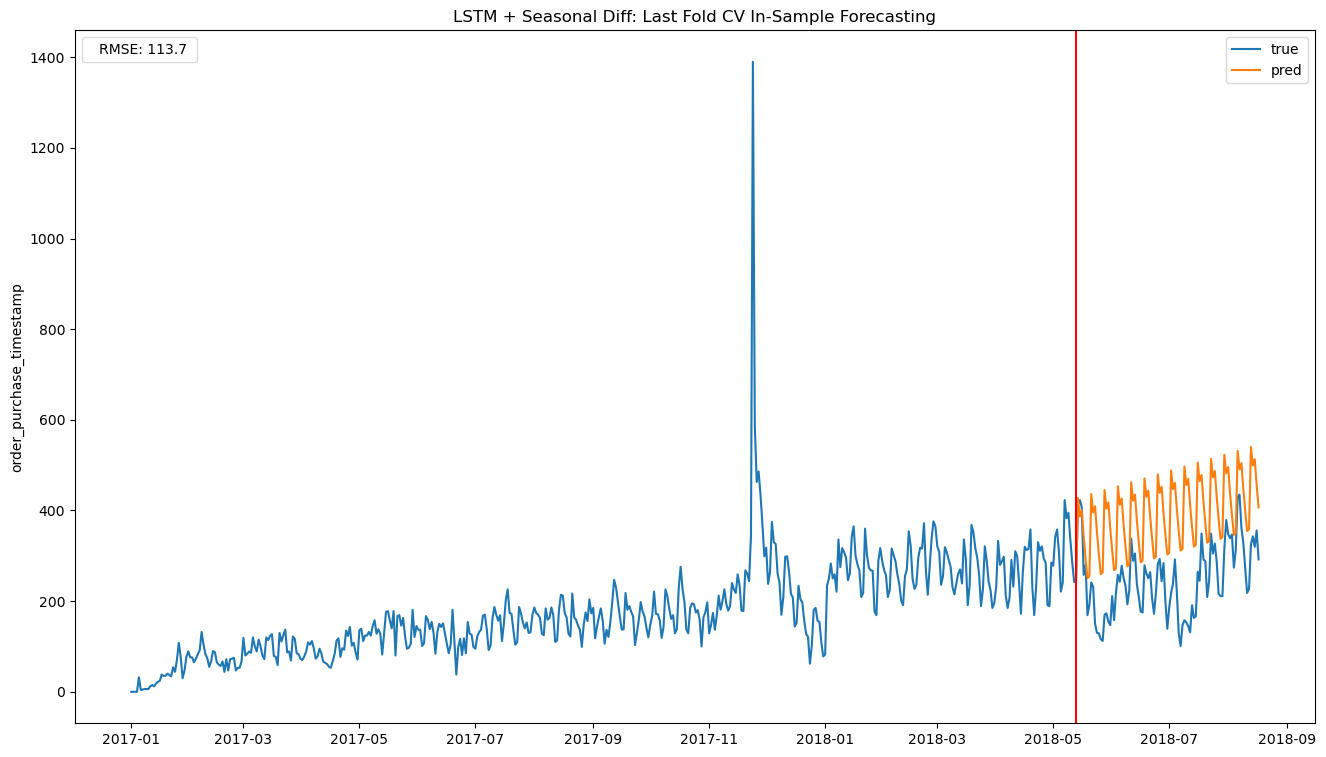

In [93]:
title = 'LSTM + Seasonal Diff'
data = diff_history.copy()
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    reset_random_seeds()
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    xi = history.reindex_like(train).tail(N_FEATURES)
    pred = diff_inv_fix(pred, xi).iloc[N_FEATURES:]
    test = diff_inv_fix(test, xi).iloc[N_FEATURES:]
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title)

### Grid Search on best learning rate

In [94]:
def gscv(learning_rate):
    global diff_history
    data = diff_history.copy()
    rmse = []
    smape_pct = []
    for train_id, test_id in tscv.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        ss = StandardScaler()
        ss.fit(train.values.reshape(-1,1))
        train_input = ss.transform(train.values.reshape(-1,1))

        # First test set prediction using 7 inputs and 1 label: total 8 observations
        test_input = train_input[-(N_FEATURES+1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

        clear_session()
        reset_random_seeds()
        model = Sequential()
        model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
        model.add(Dense(1, kernel_initializer='zeros'))

        early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
        h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
        pred = np.empty(test.shape[0])
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose=False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
            test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        xi = history.reindex_like(train).tail(N_FEATURES)
        pred = diff_inv_fix(pred, xi).iloc[N_FEATURES:]
        test = diff_inv_fix(test, xi).iloc[N_FEATURES:]
        rmse.append(np.sqrt(mean_squared_error(test, pred)))
        smape_pct.append(smape(test, pred))
    return np.mean(rmse)

learning_rates = np.logspace(-3, 1, 5)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning

learning_rate
0          0.001
1          0.010
2          0.100
3          1.000
4         10.000

In [95]:
%%time
tuning['rmse'] = tuning.apply(lambda x: gscv(x.learning_rate), axis=1)

Wall time: 3min 15s


In [96]:
tuning.query('rmse == rmse.min()')

learning_rate        rmse
0          0.001  113.652551

<a id="res_lstm"></a>

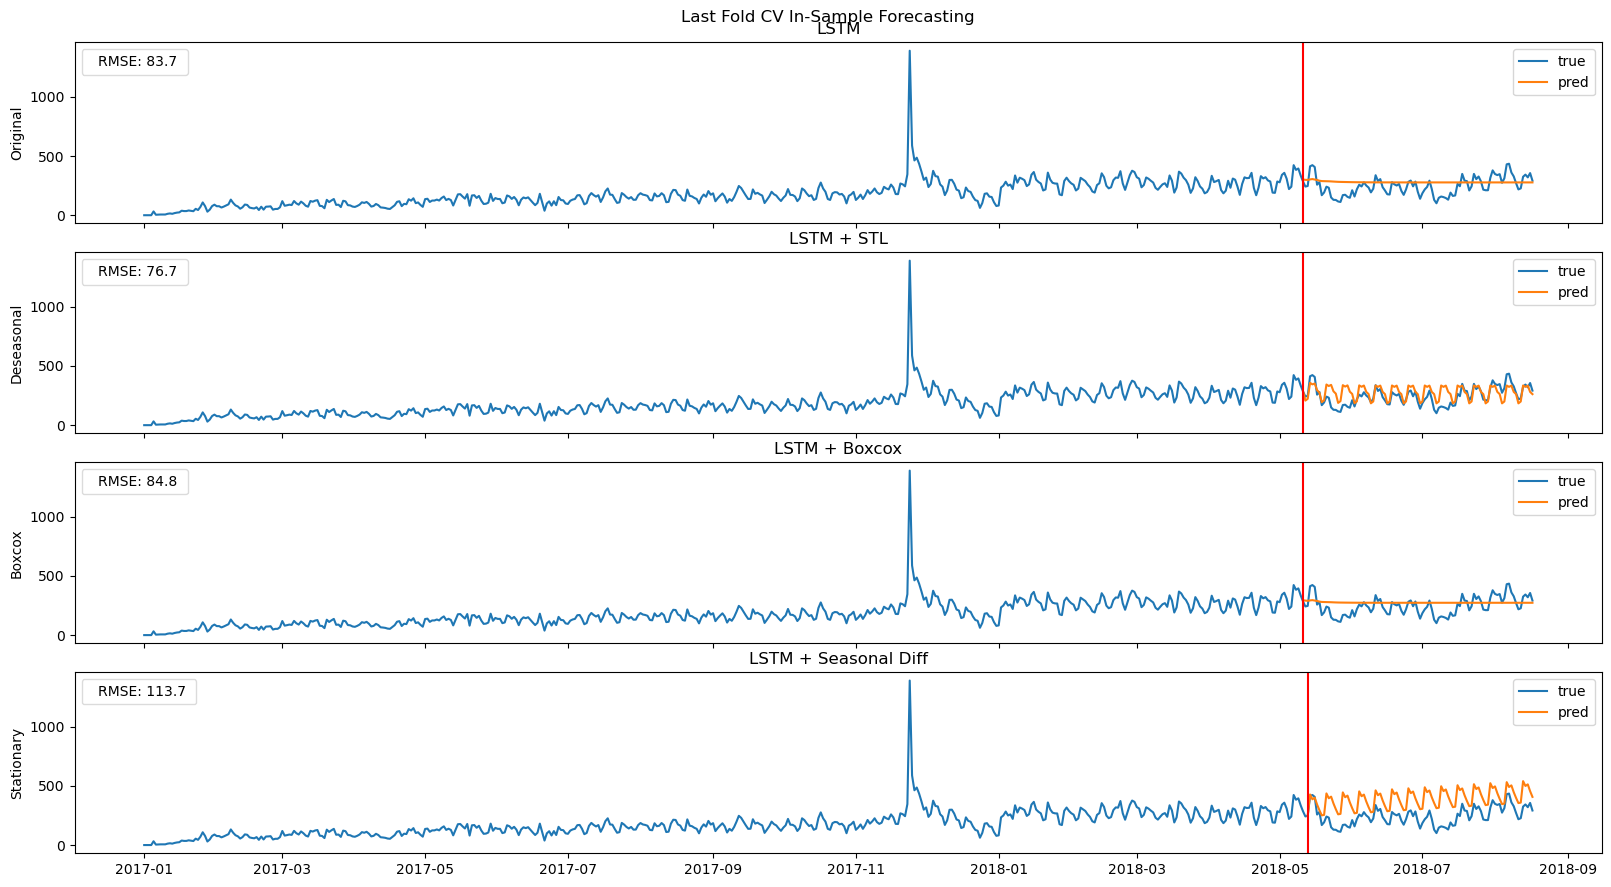

In [97]:
rmse = []
smape_pct = []
for train_id, test_id in tscv.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ss = StandardScaler()
    ss.fit(train.values.reshape(-1,1))
    train_input = ss.transform(train.values.reshape(-1,1))
    
    # First test set prediction using 7 inputs and 1 label: total 8 observations
    test_input = train_input[-(N_FEATURES+1):]
    test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    train_gen = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

    clear_session()
    reset_random_seeds()
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False))
    model.add(Dense(1, kernel_initializer='zeros'))
    
    early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)
    pred = np.empty(test.shape[0])
    for i in range(len(pred)):
        prediction = model.predict(test_gen, verbose=False)
        pred[i] = prediction
        test_input = np.delete(test_input, 0, 0)
        test_input = np.concatenate((test_input, np.array(prediction).reshape(-1,1)), axis=0)
        test_gen = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
    pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
    xi = history.reindex_like(train).tail(N_FEATURES)
    pred = diff_inv_fix(pred, xi).iloc[N_FEATURES:]
    test = diff_inv_fix(test, xi).iloc[N_FEATURES:]
    rmse.append(np.sqrt(mean_squared_error(test, pred)))
    smape_pct.append(smape(test, pred))
plot(test.index, pred, rmse, smape_pct, title, figs, axs[3])

In [98]:
record(algo=title, rmse=np.mean(rmse), smape_pct=np.mean(smape_pct))

algo         rmse   smape_pct
0                   Time-Series Regression    89.229542   30.749100
1             Time-Series Regression + STL    77.199685   27.672147
2          Time-Series Regression + Boxcox    88.674419   31.035474
3   Time-Series Regression + Seasonal Diff    90.438505   28.289077
4                    Exponential Smoothing    73.152984   21.895807
5              Exponential Smoothing + STL    67.175504   21.363917
6           Exponential Smoothing + Boxcox    73.591691   21.740791
7    Exponential Smoothing + Seasonal Diff  4533.139192  107.501647
8                                   SARIMA    85.651922   27.336142
9                         Auto ARIMA + STL    92.520916   28.986918
10                         SARIMA + BOXCOX    79.424015   26.597737
11              Auto ARIMA + Seasonal Diff    83.124392   31.926240
12                                    LSTM    83.734142   29.853399
13                              LSTM + STL    76.732163   27.514312
14                           LSTM + Boxcox    84.833232   30.580378
15                    LSTM + Seasonal Diff   113.652551   40.128389

<a id="compare"></a>
# [&#8629;](#toc) Model Evaluation

In [99]:
result = (
    result
    .assign(cat=lambda x: x.algo.apply(lambda s: re.sub(r'([^(\s\+)]+)\s\+.+', r'\g<1>', s)))
    .sort_values('rmse')
)

In [100]:
result.nsmallest(5, 'rmse')

algo       rmse  smape_pct  \
5      Exponential Smoothing + STL  67.175504  21.363917   
4            Exponential Smoothing  73.152984  21.895807   
6   Exponential Smoothing + Boxcox  73.591691  21.740791   
13                      LSTM + STL  76.732163  27.514312   
1     Time-Series Regression + STL  77.199685  27.672147   

                       cat  
5    Exponential Smoothing  
4    Exponential Smoothing  
6    Exponential Smoothing  
13                    LSTM  
1   Time-Series Regression

In [101]:
result.nsmallest(5, 'smape_pct')

algo       rmse  smape_pct  \
5      Exponential Smoothing + STL  67.175504  21.363917   
6   Exponential Smoothing + Boxcox  73.591691  21.740791   
4            Exponential Smoothing  73.152984  21.895807   
10                 SARIMA + BOXCOX  79.424015  26.597737   
8                           SARIMA  85.651922  27.336142   

                      cat  
5   Exponential Smoothing  
6   Exponential Smoothing  
4   Exponential Smoothing  
10                 SARIMA  
8                  SARIMA

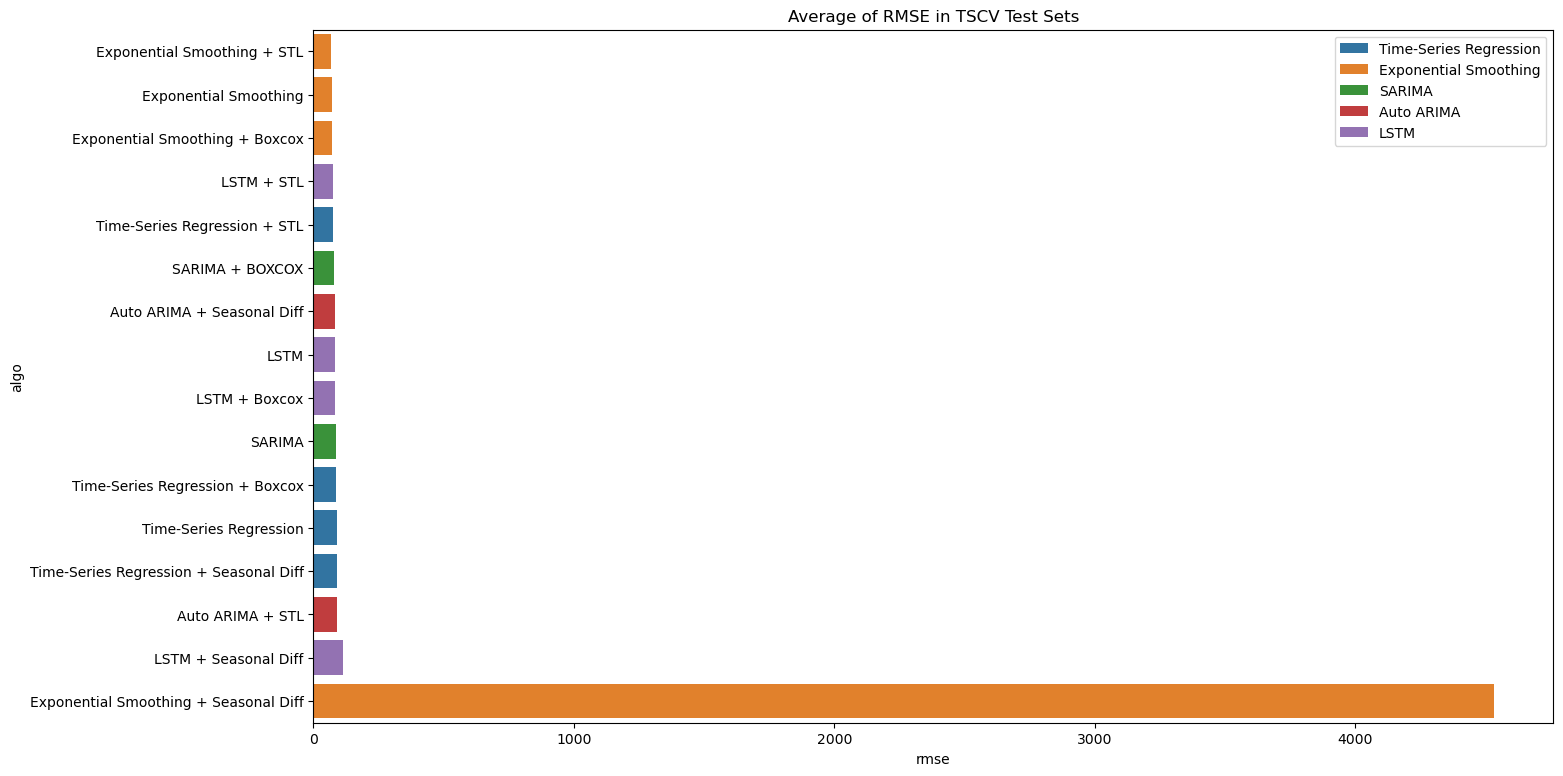

In [102]:
hue_order = ['Time-Series Regression', 'Exponential Smoothing', 'SARIMA', 'Auto ARIMA', 'LSTM']
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(data=result, x='rmse', y='algo', hue='cat', hue_order=hue_order, orient='h', ax=ax, dodge=False)
ax.set_title('Average of RMSE in TSCV Test Sets')
ax.legend().set_title(None)
plt.show()

Within the scope of this project, from the metric evaluation, the best model with least RMSE and SMAPE is Exponential Soothing + STL. 
- Top 3 models with minimal RMSE belongs to Exponential Smoothing family. 
- Data transformation method STL has been efficient in bring down the RMSE in this case. 
- Seasonal differencing data with exponential smoothing performed the worst among all. 

|        Model        |    RMSE   | SMAPE |   Category   | 
|:-------------------:|:--------------:|:-------:|:----------:|
|        Exponential Smoothing + STL  |	67.18  |  21.36  | 	Exponential Smoothing         | 
|  Exponential Smoothing  |	 73.15  |	21.90 |  Exponential Smoothing  |
|	Exponential Smoothing + Boxcox  |	73.59  |	21.74  |	Exponential Smoothing  |
|	LSTM + STL  |	76.73  |	27.51  |	LSTM  |
|	Time-Series Regression + STL  |	77.20  |	27.67  |	Time-Series Regression   |

<a id="forecast"></a>
# [&#8629;](#toc) 🧙‍♂️ Forecast

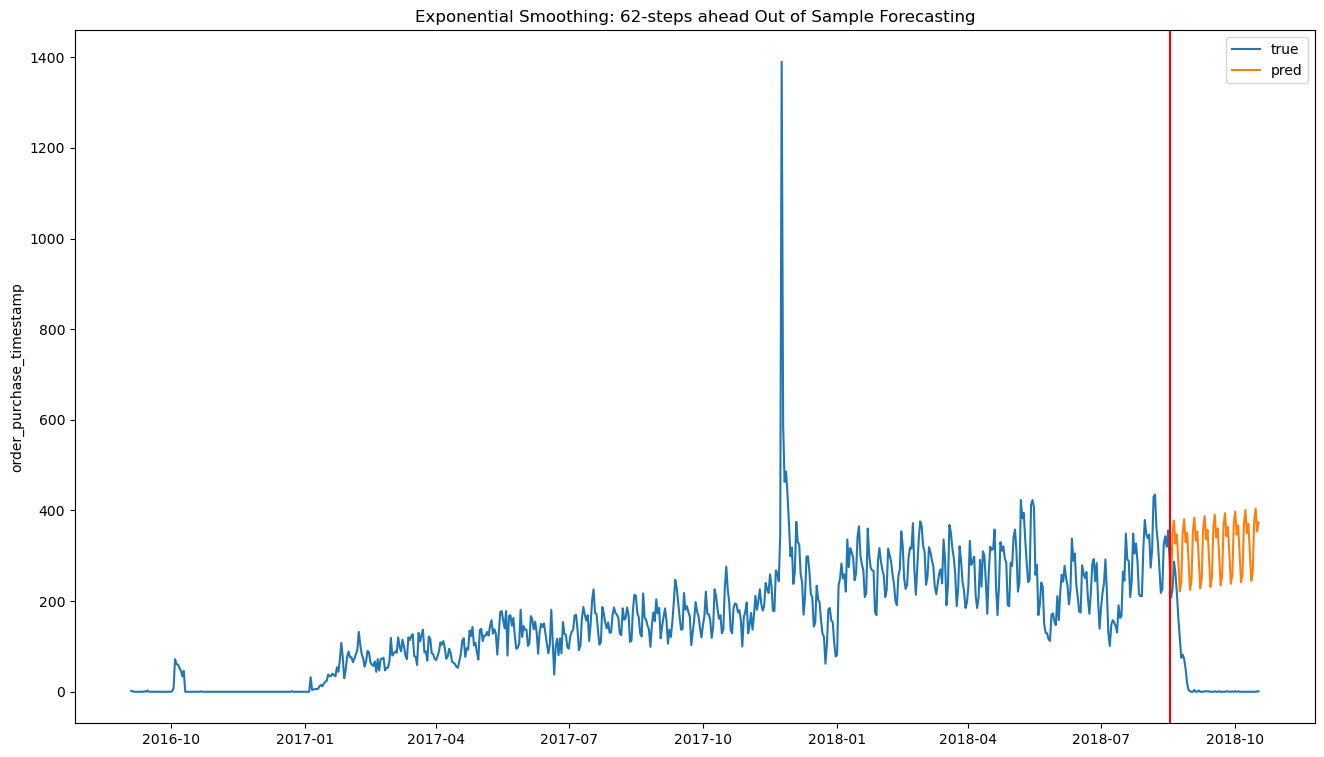

In [112]:
ES = ExponentialSmoothing
model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=7)
fit_kwargs = dict(smoothing_level=0, smoothing_trend=0.3, smoothing_seasonal=0.4, method='ls')
stlf = STLForecast(history, ES, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
pred = stlf.forecast(pred_period.shape[0])

fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=full_history.index, y=full_history, label='true')
sns.lineplot(x=pred_period, y=pred, label='pred')
ax.axvline(x=pred_period[0], color='red')
ax.set_title('Exponential Smoothing: 62-steps ahead Out of Sample Forecasting')
plt.show()

In [113]:
# save model
pickle.dump(stlf, open('../model/stlf_model.pkl', 'wb'))

In [114]:
# load model & predict
stlf_prickled_model = pickle.load(open('../model/stlf_model.pkl', 'rb'))
stlf_result_pred = stlf_prickled_model.forecast(pred_period.shape[0])
stlf_result_pred

2018-08-18    218.009612
2018-08-19    237.419292
2018-08-20    349.570066
2018-08-21    377.402516
2018-08-22    326.627223
                 ...    
2018-10-14    264.285992
2018-10-15    376.436766
2018-10-16    404.269216
2018-10-17    353.493923
2018-10-18    373.843939
Freq: D, Length: 62, dtype: float64

In [116]:
result.to_csv('../datasets/forecasting_error_result.csv')

In [ ]:
# # save model
# pickle.dump(es, open('../model/es_model.pkl', 'wb'))
# # load model & predict
# es_prickled_model = pickle.load(open('../model/es_model.pkl', 'rb'))
# es_result_pred = es_prickled_model.predict(pred_period.shape[0])
# es_result_pred
# es_result_forecast = es_prickled_model.forecast(pred_period.shape[0])
# es_result_forecast

<a id="Conclusion"></a>
# [&#8629;](#toc) Conclusion 


By using the best model to forecast the sales for subsequent two months, we expect the daily order count has a constant growth with the weekly seasonal applied after 17 August 2018. The order count shouldn’t be a drop as given from the data. For the forecasted period between 17 August to 17 October 2018, both storesellers and Olist should prepare more resources to meet the surge of order purchase demand.

In conclusion, we want to forecast the subsequent two months’ order count with the best forecasting model. The Exponential Smoothing with STL transformation can be applied on the original data to yield the lowest RMSE. 


## Limitations of the modelling approach
1. The selected models are currently based on univariate factor. Multivariate factors can also be considered and explored with the addition of exogenous variables. There are many factors account for forecasting sales demand.   
2. There are many more advanced time series forecasting models are not being tested yet, such as Bidirectional/ Stacked LSTM or hybrid models with Prophet. 
3. The current models include only from 2017-01-01 to 2018-08-17. It will be better if we can observe time series components for another year.
4. Geolocation and correlated factor of this dataset have not being considered yet. 

## Recommendation
**Forecastability of business**
1. To make a business more forecastable is to manage more aspects of the supply chain. Direct store delivery supply chains typically have 10% lower weekly error than warehouse-delivered businesses. The two key reasons for this are direct visibility into consumer demand and control over retailer execution. Companies for which direct store delivery is not a feasible option should consider expanding vendor-managed inventory programs and leveraging store data to sense demand at retailer distribution centers.

**Demand forecasting**
1. To better understand respective market demand, storesellers can start looking at their own product catergory. Then examine each category on a national level to determine what was driving the demand for these products. From there, they can dive into a more granular level, taking in economic factors for certain markets such as employment and cost of living to build predictive models. With this information, the storesellers will able to build predictive models for each of its market areas, which procurement used to stock shelves with the goods consumers were ready and able to purchase.
1. Storesellers can also practise more proactive demand forecasting which does not only make use of historical data but external factors too.
1. As future is uncertain, forecasts must often be revised, and actual results can vary greatly.    


References:
1. https://www.e2open.com/wp-content/uploads/2019/02/2018_Forecasting_and_Inventory_Benchmark_Study_white_paper_digital.pdf
2. https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp
3. https://github.com/LarsTinnefeld/olist_ecom_analysis
4. https://github.com/juloi/udacity_ds_nanodg_blog_post/tree/master/olist_ecommerce_eda